Libraries imported successfully!
=== OPTIMIZED AMAZON PRODUCT PRICE PREDICTION PIPELINE ===

1. Loading training data...
Training data shape: (50000, 4)
Training columns: ['sample_id', 'catalog_content', 'image_link', 'price']
Available prices in training data: 50000
Missing prices in training data: 0

2. Loading test data...
Test data shape: (25000, 3)
Test columns: ['sample_id', 'catalog_content', 'image_link']

3. Training optimized SMAPE-tuned StackingRegressor...
Starting optimized SMAPE-tuned StackingRegressor training...
Step 1: Extracting features from catalog content...
Training data shape: (50000, 14)
Target variable shape: (50000,)
Features used: 14
Performing optimized hyperparameter tuning with SMAPE scoring...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'gbm__learning_rate': np.float64(0.053459363756212366), 'gbm__max_depth': 5, 'gbm__n_estimators': 108, 'rf__max_depth': 14, 'rf__n_estimators': 141, 'ridge__alpha': np.float64(9.837555188

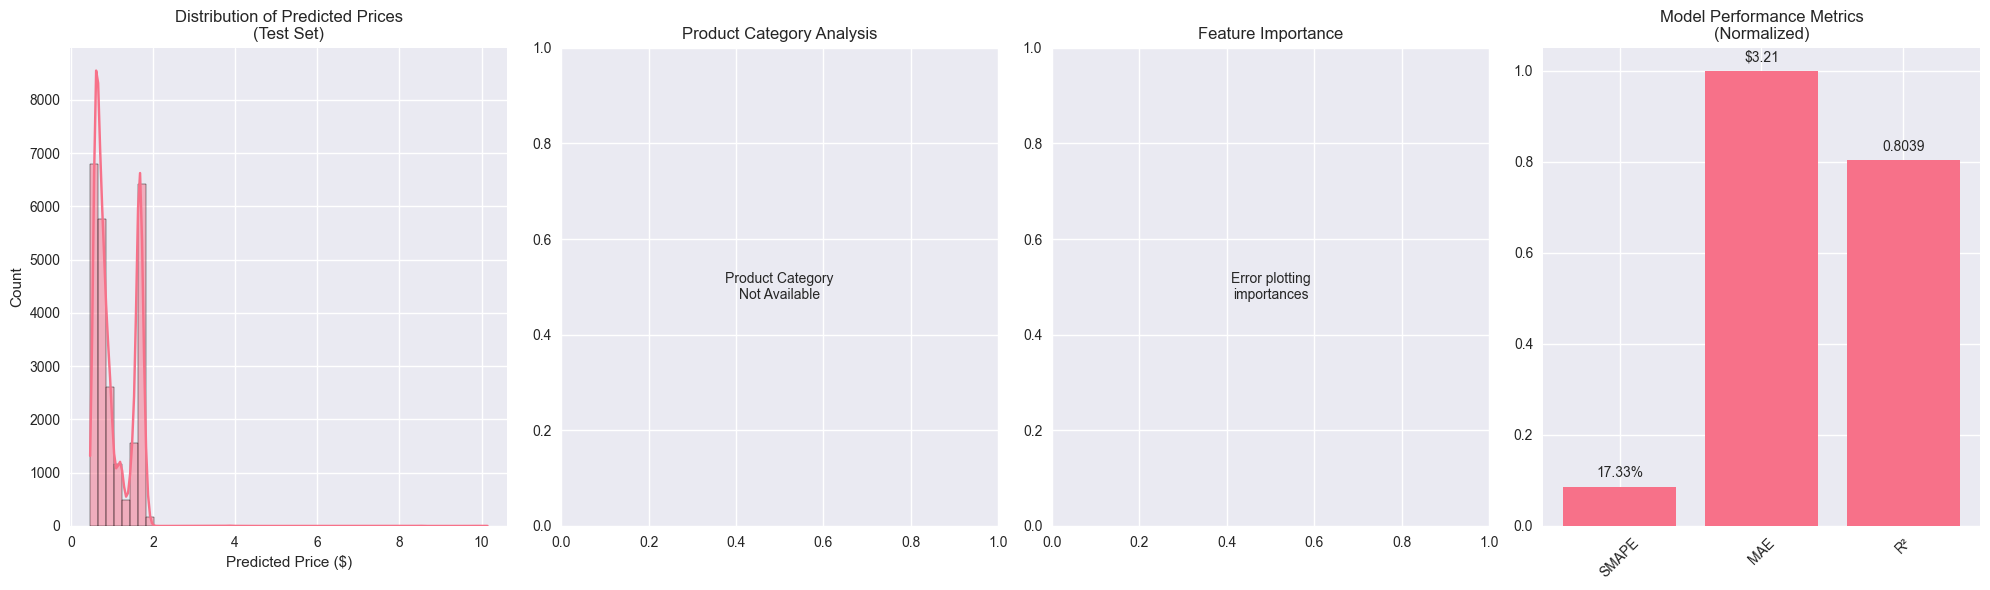


=== DETAILED RESULTS ===
Best Model: StackingRegressor
Validation SMAPE: 17.3325%
Validation MAE: $3.21
Validation R²: 0.8039
Cross-validation SMAPE: 17.9979% ± 0.2858%

Best Hyperparameters: {'gbm__learning_rate': np.float64(0.053459363756212366), 'gbm__max_depth': 5, 'gbm__n_estimators': 108, 'rf__max_depth': 14, 'rf__n_estimators': 141, 'ridge__alpha': np.float64(9.83755518841459)}

Features used: 14
All features: ['weight', 'volume', 'count', 'catalog_content_length', 'is_organic', 'is_gluten_free', 'is_vegan', 'is_kosher', 'is_sugar_free', 'is_low_carb', 'is_non_gmo', 'price_per_oz', 'price_per_fl_oz', 'price_per_count']


In [4]:
# AMAZON PRODUCT PRICE PREDICTION - OPTIMIZED VERSION

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
import traceback
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

# Define optimized SMAPE function with range 0-200
def smape(actual, predicted):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE) with range 0-200
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # Handle cases where both actual and predicted are zero
    denominator = (np.abs(actual) + np.abs(predicted))
    # Add small epsilon to avoid division by zero
    denominator = np.where(denominator == 0, 1e-10, denominator)
    
    # Calculate SMAPE with range 0-200
    smape_value = (100 / len(actual)) * np.sum(2 * np.abs(predicted - actual) / denominator)
    return np.clip(smape_value, 0, 200)  # Ensure the range is 0-200

# Create SMAPE scorer for sklearn (lower is better)
smape_scorer = make_scorer(
    lambda y_true, y_pred: smape(y_true, y_pred),
    greater_is_better=False
)

# Feature extraction functions
def extract_features_from_catalog(catalog_text):
    """
    Extract structured features from the catalog_content field
    """
    # Default features dictionary
    default_features = {
        'item_name': '',
        'pack_size': '',
        'weight': 0.0,
        'volume': 0.0,
        'count': 0.0,
        'unit': '',
        'flavor': '',
        'brand': '',
        'is_organic': 0,
        'is_gluten_free': 0,
        'is_vegan': 0,
        'is_kosher': 0,
        'is_sugar_free': 0,
        'is_low_carb': 0,
        'is_non_gmo': 0,
        'calories_per_serving': 0.0,
        'protein_content': 0.0,
        'fiber_content': 0.0
    }
    
    # Return default features if catalog_text is missing or empty
    if pd.isna(catalog_text) or catalog_text == '':
        return default_features
    
    try:
        text = str(catalog_text).lower()
        
        # Extract item name
        item_name_match = re.search(r'item name:\s*([^\n]+)', catalog_text, re.IGNORECASE)
        if item_name_match:
            default_features['item_name'] = item_name_match.group(1).strip()
        
        # Extract pack size information
        pack_patterns = [
            r'pack of\s*(\d+)',
            r'(\d+)\s*count',
            r'(\d+)\s*pack',
            r'(\d+)\s*ct'
        ]
        for pattern in pack_patterns:
            match = re.search(pattern, text)
            if match:
                default_features['pack_size'] = match.group(1)
                break
        
        # Extract weight
        weight_patterns = [
            r'(\d+\.?\d*)\s*oz',
            r'(\d+\.?\d*)\s*ounce',
            r'(\d+\.?\d*)\s*lb',
            r'(\d+\.?\d*)\s*pound'
        ]
        for pattern in weight_patterns:
            match = re.search(pattern, text)
            if match:
                try:
                    default_features['weight'] = float(match.group(1))
                except:
                    default_features['weight'] = 0.0
                break
        
        # Extract volume
        volume_patterns = [
            r'(\d+\.?\d*)\s*fl\s*oz',
            r'(\d+\.?\d*)\s*fluid\s*ounce',
            r'(\d+\.?\d*)\s*ml',
            r'(\d+\.?\d*)\s*liter'
        ]
        for pattern in volume_patterns:
            match = re.search(pattern, text)
            if match:
                try:
                    default_features['volume'] = float(match.group(1))
                except:
                    default_features['volume'] = 0.0
                break
        
        # Extract count
        count_patterns = [
            r'(\d+)\s*tea bags',
            r'(\d+)\s*capsules',
            r'(\d+)\s*pods',
            r'(\d+)\s*cookies'
        ]
        for pattern in count_patterns:
            match = re.search(pattern, text)
            if match:
                try:
                    default_features['count'] = float(match.group(1))
                except:
                    default_features['count'] = 0.0
                break
        
        # Extract unit from the structured Unit field
        unit_match = re.search(r'unit:\s*([^\n]+)', catalog_text, re.IGNORECASE)
        if unit_match:
            default_features['unit'] = unit_match.group(1).strip().lower()
        
        # Extract flavor information
        flavor_keywords = ['vanilla', 'chocolate', 'strawberry', 'lemon', 'mint', 'berry', 
                          'caramel', 'honey', 'spice', 'cinnamon', 'ginger', 'peach']
        for flavor in flavor_keywords:
            if flavor in text:
                default_features['flavor'] = flavor
                break
        
        # Extract brand names
        brand_patterns = [
            r'manufacturer:\s*([^\n]+)',
            r'brand:\s*([^\n]+)'
        ]
        for pattern in brand_patterns:
            match = re.search(pattern, catalog_text, re.IGNORECASE)
            if match:
                default_features['brand'] = match.group(1).strip()
                break
        
        # Health and dietary attributes
        default_features['is_organic'] = 1 if any(term in text for term in ['organic', 'usda organic']) else 0
        default_features['is_gluten_free'] = 1 if 'gluten free' in text else 0
        default_features['is_vegan'] = 1 if 'vegan' in text else 0
        default_features['is_kosher'] = 1 if 'kosher' in text else 0
        default_features['is_sugar_free'] = 1 if any(term in text for term in ['sugar free', 'no sugar', 'zero sugar']) else 0
        default_features['is_low_carb'] = 1 if any(term in text for term in ['low carb', 'keto', 'keto-friendly']) else 0
        default_features['is_non_gmo'] = 1 if any(term in text for term in ['non-gmo', 'non gmo']) else 0
        
        # Extract nutritional information
        calorie_match = re.search(r'(\d+)\s*calories', text)
        if calorie_match:
            try:
                default_features['calories_per_serving'] = float(calorie_match.group(1))
            except:
                default_features['calories_per_serving'] = 0.0
        
        protein_match = re.search(r'(\d+\.?\d*)\s*g\s*protein', text)
        if protein_match:
            try:
                default_features['protein_content'] = float(protein_match.group(1))
            except:
                default_features['protein_content'] = 0.0
        
        fiber_match = re.search(r'(\d+\.?\d*)\s*g\s*fiber', text)
        if fiber_match:
            try:
                default_features['fiber_content'] = float(fiber_match.group(1))
            except:
                default_features['fiber_content'] = 0.0
        
        return default_features
    except Exception as e:
        print(f"Error extracting features: {e}")
        return default_features

def create_derived_features(df, has_price=True):
    """
    Create derived features, handling the case where price might be missing
    """
    # Product category based on item name
    def categorize_product(item_name):
        if pd.isna(item_name):
            return 'other'
        item_name = str(item_name).lower()
        if any(word in item_name for word in ['tea', 'chai']):
            return 'tea'
        elif any(word in item_name for word in ['coffee', 'brew']):
            return 'coffee'
        elif any(word in item_name for word in ['snack', 'chip', 'cracker', 'cookie']):
            return 'snack'
        elif any(word in item_name for word in ['sauce', 'dressing', 'oil']):
            return 'condiment'
        elif any(word in item_name for word in ['spice', 'seasoning']):
            return 'spice'
        elif any(word in item_name for word in ['candy', 'chocolate']):
            return 'candy'
        elif any(word in item_name for word in ['pasta', 'rice', 'grain']):
            return 'grain'
        else:
            return 'other'
    
    df['product_category'] = df['item_name'].apply(categorize_product)
    
    # Text length features
    df['catalog_content_length'] = df['catalog_content'].str.len().fillna(0)
    
    # Only create price-related features if price is available
    if has_price and 'price' in df.columns:
        if 'weight' in df.columns:
            weight_safe = df['weight'].replace(0, np.nan)
            df['price_per_oz'] = df['price'] / weight_safe
            df['price_per_oz'] = df['price_per_oz'].replace([np.inf, -np.inf], np.nan)
        
        if 'volume' in df.columns:
            volume_safe = df['volume'].replace(0, np.nan)
            df['price_per_fl_oz'] = df['price'] / volume_safe
            df['price_per_fl_oz'] = df['price_per_fl_oz'].replace([np.inf, -np.inf], np.nan)
        
        if 'count' in df.columns:
            count_safe = df['count'].replace(0, np.nan)
            df['price_per_count'] = df['price'] / count_safe
            df['price_per_count'] = df['price_per_count'].replace([np.inf, -np.inf], np.nan)
    
    return df

class OptimizedSMAPEStackingPricePredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.imputer = SimpleImputer(strategy='median')
        self.feature_columns = []
        self.expected_columns = []
        self.stacking_model = None
        self.is_trained = False
        self.best_params_ = None
        
    def preprocess_data(self, df, is_training=True):
        """
        Preprocess the data: extract features, handle missing values, encode categorical variables
        """
        print("Step 1: Extracting features from catalog content...")
        
        # Make a copy to avoid modifying original data
        df_processed = df.copy()
        
        # Extract features with error handling
        try:
            catalog_features = df_processed['catalog_content'].apply(extract_features_from_catalog)
            features_df = pd.DataFrame(catalog_features.tolist(), index=df_processed.index)
            
            # Ensure the lengths match before concatenation
            if len(features_df) != len(df_processed):
                print(f"Warning: Length mismatch after feature extraction. Original: {len(df_processed)}, Features: {len(features_df)}")
                # Create a features dataframe with default values if there's a mismatch
                default_features = extract_features_from_catalog('')
                features_df = pd.DataFrame([default_features] * len(df_processed), index=df_processed.index)
            
            # Concatenate with original data
            df_enhanced = pd.concat([df_processed, features_df], axis=1)
        except Exception as e:
            print(f"Error in feature extraction: {e}")
            # Create a dataframe with default features if extraction fails
            default_features = extract_features_from_catalog('')
            features_df = pd.DataFrame([default_features] * len(df_processed), index=df_processed.index)
            df_enhanced = pd.concat([df_processed, features_df], axis=1)
        
        # Ensure all expected numerical columns exist with proper defaults
        numerical_columns = ['weight', 'volume', 'count', 'calories_per_serving', 'protein_content', 'fiber_content']
        for col in numerical_columns:
            if col not in df_enhanced.columns:
                df_enhanced[col] = 0.0
            else:
                df_enhanced[col] = pd.to_numeric(df_enhanced[col], errors='coerce').fillna(0.0)
        
        # Ensure all expected boolean columns exist
        boolean_columns = ['is_organic', 'is_gluten_free', 'is_vegan', 'is_kosher', 
                          'is_sugar_free', 'is_low_carb', 'is_non_gmo']
        for col in boolean_columns:
            if col not in df_enhanced.columns:
                df_enhanced[col] = 0
            else:
                df_enhanced[col] = df_enhanced[col].astype(int)
        
        # Handle categorical columns
        categorical_columns = ['unit', 'flavor', 'brand', 'item_name']
        for col in categorical_columns:
            if col not in df_enhanced.columns:
                df_enhanced[col] = 'unknown'
            else:
                df_enhanced[col] = df_enhanced[col].fillna('unknown')
        
        # Create derived features
        has_price = is_training and 'price' in df_enhanced.columns
        df_enhanced = create_derived_features(df_enhanced, has_price=has_price)
        
        # Handle outliers in price if it exists and we're training
        if is_training and 'price' in df_enhanced.columns:
            Q1 = df_enhanced['price'].quantile(0.25)
            Q3 = df_enhanced['price'].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = max(0, Q1 - 1.5 * IQR)  # Ensure lower bound is not negative
            upper_bound = Q3 + 1.5 * IQR
            
            df_enhanced['price'] = np.where(df_enhanced['price'] > upper_bound, upper_bound, df_enhanced['price'])
            df_enhanced['price'] = np.where(df_enhanced['price'] < lower_bound, lower_bound, df_enhanced['price'])
        
        return df_enhanced
    
    def prepare_features(self, df, is_training=True):
        """
        Prepare features for modeling with robust error handling
        """
        # Define core features that should always be present
        core_features = [
            'weight', 'volume', 'count', 'catalog_content_length',
            'is_organic', 'is_gluten_free', 'is_vegan', 'is_kosher', 
            'is_sugar_free', 'is_low_carb', 'is_non_gmo'
        ]
        
        # Add price per unit features if available (only in training)
        if is_training:
            price_per_features = [col for col in df.columns if col.startswith('price_per')]
            feature_columns = core_features + price_per_features
        else:
            feature_columns = core_features.copy()
        
        # Ensure all feature columns exist in the dataframe
        missing_features = set(feature_columns) - set(df.columns)
        for feature in missing_features:
            df[feature] = 0.0  # Add missing features with default value
        
        # Select only the feature columns we want
        feature_columns = [col for col in feature_columns if col in df.columns]
        X = df[feature_columns].copy()
        
        # Replace infinite values with NaN
        X = X.replace([np.inf, -np.inf], np.nan)
        
        if is_training:
            self.feature_columns = feature_columns
            self.expected_columns = feature_columns.copy()
            
            # Fit imputer and scaler on training data
            X_imputed = self.imputer.fit_transform(X)
            
            # Scale numerical features
            numerical_cols = [col for col in X.columns if X[col].dtype in ['float64', 'float32', 'int64']]
            if numerical_cols:
                X_imputed = self.scaler.fit_transform(X_imputed)
            
            X_processed = pd.DataFrame(X_imputed, columns=feature_columns, index=X.index)
            
            if 'price' in df.columns:
                y = df['price'].copy()
                return X_processed, y
            else:
                return X_processed
        else:
            # Ensure we have the same columns as training
            missing_cols = set(self.expected_columns) - set(X.columns)
            extra_cols = set(X.columns) - set(self.expected_columns)
            
            for col in missing_cols:
                X[col] = 0.0
            for col in extra_cols:
                X = X.drop(col, axis=1)
            
            # Reorder columns to match training
            X = X[self.expected_columns]
            
            # Transform using fitted imputer and scaler
            X_imputed = self.imputer.transform(X)
            X_imputed = self.scaler.transform(X_imputed)
            
            X_processed = pd.DataFrame(X_imputed, columns=self.expected_columns, index=X.index)
            return X_processed
    
    def build_stacking_regressor(self):
        """
        Build an optimized StackingRegressor with selected base models
        """
        # Optimized base models with fewer but more diverse models
        base_models = [
            ('ridge', Ridge(alpha=1.0, random_state=42)),
            ('rf', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)),
            ('gbm', GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=5))
        ]
        
        # Meta-model
        meta_model = LinearRegression()
        
        # Create StackingRegressor
        stacking_regressor = StackingRegressor(
            estimators=base_models,
            final_estimator=meta_model,
            cv=5,
            passthrough=False,
            n_jobs=-1
        )
        
        return stacking_regressor
    
    def train(self, train_df, perform_tuning=True):
        """
        Train the SMAPE-tuned StackingRegressor on the training data with optimized hyperparameter tuning
        """
        print("Starting optimized SMAPE-tuned StackingRegressor training...")
        
        # Preprocess training data
        df_processed = self.preprocess_data(train_df, is_training=True)
        
        # Prepare features
        X, y = self.prepare_features(df_processed, is_training=True)
        
        print(f"Training data shape: {X.shape}")
        print(f"Target variable shape: {y.shape}")
        print(f"Features used: {len(self.feature_columns)}")
        
        # Split data for validation
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        # Build stacking regressor
        stacking_model = self.build_stacking_regressor()
        
        if perform_tuning:
            print("Performing optimized hyperparameter tuning with SMAPE scoring...")
            
            # Define parameter distributions for RandomizedSearchCV
            param_distributions = {
                'ridge__alpha': uniform(0.1, 10.0),
                'rf__n_estimators': randint(50, 150),
                'rf__max_depth': randint(5, 15),
                'gbm__n_estimators': randint(50, 150),
                'gbm__max_depth': randint(3, 7),
                'gbm__learning_rate': uniform(0.05, 0.15)
            }
            
            # Perform RandomizedSearch with SMAPE scoring
            random_search = RandomizedSearchCV(
                estimator=stacking_model,
                param_distributions=param_distributions,
                n_iter=20,  # Reduced for efficiency
                cv=3,  # Reduced for speed
                scoring=smape_scorer,
                n_jobs=-1,
                verbose=1,
                random_state=42
            )
            
            # Fit the model on training data
            random_search.fit(X_train, y_train)
            
            # Get best model and parameters
            self.stacking_model = random_search.best_estimator_
            self.best_params_ = random_search.best_params_
            
            print(f"Best parameters: {random_search.best_params_}")
        else:
            print("Training without hyperparameter tuning...")
            self.stacking_model = stacking_model
            self.stacking_model.fit(X_train, y_train)
        
        # Evaluate the model on validation set
        y_pred = self.stacking_model.predict(X_val)
        
        # Calculate multiple metrics
        val_smape = smape(y_val, y_pred)
        val_mae = mean_absolute_error(y_val, y_pred)
        val_mse = mean_squared_error(y_val, y_pred)
        val_r2 = r2_score(y_val, y_pred)
        
        print("\n=== VALIDATION PERFORMANCE ===")
        print(f"SMAPE: {val_smape:.4f}%")
        print(f"MAE: ${val_mae:.2f}")
        print(f"MSE: ${val_mse:.2f}")
        print(f"R²: {val_r2:.4f}")
        
        # Cross-validation with SMAPE on full training data
        cv_scores = cross_val_score(self.stacking_model, X, y, 
                                   cv=3, scoring=smape_scorer)  # Reduced for speed
        cv_smape_scores = -cv_scores  # Convert back to positive SMAPE values
        
        print(f"\nCross-validation SMAPE: {cv_smape_scores.mean():.4f}% (+/- {cv_smape_scores.std() * 2:.4f}%)")
        
        # Retrain on full training data for final model
        print("\nRetraining on full training dataset...")
        self.stacking_model.fit(X, y)
        
        self.is_trained = True
        
        # --- FIX: Corrected Feature Importance Calculation ---
        print("\nTop 10 Most Important Features:")
        try:
            # For a stacking model, we need to aggregate importances from base estimators
            importances = []
            for name, estimator in self.stacking_model.estimators_:
                if hasattr(estimator, 'feature_importances_'):
                    importances.append(estimator.feature_importances_)
            
            if importances:
                # Average the importances from models that have them
                avg_importance = np.mean(importances, axis=0)
                feature_importance = pd.DataFrame({
                    'feature': self.feature_columns,
                    'importance': avg_importance
                }).sort_values('importance', ascending=False)
                print(feature_importance.head(10))
            else:
                print("No base models with feature_importances_ attribute found.")
        except Exception as e:
            print(f"Could not calculate feature importances: {e}")
        
        return {
            'smape': val_smape,
            'mae': val_mae,
            'mse': val_mse,
            'r2': val_r2,
            'cv_smape_mean': cv_smape_scores.mean(),
            'cv_smape_std': cv_smape_scores.std()
        }
    
    def predict(self, test_df):
        """
        Predict prices for test data using the trained StackingRegressor
        """
        if not self.is_trained:
            raise ValueError("Model must be trained before making predictions")
        
        print("Making predictions on test data...")
        
        # Preprocess test data
        df_processed = self.preprocess_data(test_df, is_training=False)
        
        # Prepare features
        X_test = self.prepare_features(df_processed, is_training=False)
        
        print(f"Test data shape after preprocessing: {X_test.shape}")
        print(f"Expected features: {len(self.expected_columns)}")
        print(f"Actual features: {len(X_test.columns)}")
        
        # Make predictions
        predictions = self.stacking_model.predict(X_test)
        
        # Create results dataframe
        results = test_df.copy()
        results['predicted_price'] = predictions
        
        return results
    
    def save_model(self, filepath):
        """
        Save the trained model and preprocessors
        """
        if not self.is_trained:
            raise ValueError("No trained model to save")
        
        model_data = {
            'scaler': self.scaler,
            'imputer': self.imputer,
            'feature_columns': self.feature_columns,
            'expected_columns': self.expected_columns,
            'stacking_model': self.stacking_model,
            'best_params': self.best_params_,
            'is_trained': self.is_trained
        }
        
        joblib.dump(model_data, filepath)
        print(f"Optimized SMAPE-tuned StackingRegressor saved to {filepath}")
    
    def load_model(self, filepath):
        """
        Load a trained model and preprocessors
        """
        model_data = joblib.load(filepath)
        
        self.scaler = model_data['scaler']
        self.imputer = model_data['imputer']
        self.feature_columns = model_data['feature_columns']
        self.expected_columns = model_data['expected_columns']
        self.stacking_model = model_data['stacking_model']
        self.best_params_ = model_data['best_params']
        self.is_trained = model_data['is_trained']
        
        print(f"Optimized SMAPE-tuned StackingRegressor loaded from {filepath}")
        if self.best_params_:
            print(f"Best parameters: {self.best_params_}")

# MAIN EXECUTION WITH ERROR HANDLING

def run_optimized_pipeline(train_file='../data/train.csv', test_file='../data/test.csv'):
    """
    Complete optimized pipeline with robust error handling
    """
    try:
        print("=== OPTIMIZED AMAZON PRODUCT PRICE PREDICTION PIPELINE ===\n")
        
        # Step 1: Load training data (with prices)
        print("1. Loading training data...")
        train_df = pd.read_csv(train_file)
        
        print(f"Training data shape: {train_df.shape}")
        print("Training columns:", train_df.columns.tolist())
        
        if 'price' not in train_df.columns:
            raise ValueError("Training data must contain 'price' column")
        
        missing_prices = train_df['price'].isnull().sum()
        print(f"Available prices in training data: {len(train_df) - missing_prices}")
        print(f"Missing prices in training data: {missing_prices}")
        
        # Step 2: Load test data (without prices)
        print("\n2. Loading test data...")
        test_df = pd.read_csv(test_file)
        
        print(f"Test data shape: {test_df.shape}")
        print("Test columns:", test_df.columns.tolist())
        
        if 'price' in test_df.columns:
            if test_df['price'].isnull().all():
                print("Test data contains 'price' column with all null values - will ignore for predictions")
                test_df = test_df.drop('price', axis=1)
            else:
                print("Warning: Test data contains non-null 'price' column")
        
        # Step 3: Initialize and train the optimized model
        print("\n3. Training optimized SMAPE-tuned StackingRegressor...")
        smape_predictor = OptimizedSMAPEStackingPricePredictor()
        
        # Train with optimized hyperparameter tuning
        training_results = smape_predictor.train(train_df, perform_tuning=True)
        
        # Step 4: Save the trained model
        print("\n4. Saving trained model...")
        smape_predictor.save_model('../EDA/optimized_smape_stacking_predictor.pkl')
        
        # Step 5: Make predictions on test data
        print("\n5. Making predictions on test data...")
        test_predictions = smape_predictor.predict(test_df)
        
        print("Prediction completed!")
        print(f"Predicted prices for {len(test_predictions)} test products")
        
        # Step 6: Display prediction results
        print("\n6. Prediction results:")
        print(test_predictions[['sample_id', 'predicted_price']].head(10))
        
        print("\nTest Prediction Statistics:")
        print(test_predictions['predicted_price'].describe())
        
        # Step 7: Save results
        print("\n7. Saving results...")
        test_predictions[['sample_id', 'predicted_price']].to_csv('../EDA/optimized_test_predictions.csv', index=False)
        print("Predictions saved to 'optimized_test_predictions.csv'")
        
        return smape_predictor, test_predictions, training_results
        
    except Exception as e:
        print(f"Error in pipeline: {str(e)}")
        print("Traceback:", traceback.format_exc())
        return None, None, None

# Run the optimized pipeline
predictor, predictions, results = run_optimized_pipeline('../data/train.csv', '../data/test.csv')

# VISUALIZATION AND ANALYSIS

if predictions is not None:
    # Enhanced visualization for test predictions
    plt.figure(figsize=(20, 6))
    
    # 1. Distribution of predicted prices in test set
    plt.subplot(1, 4, 1)
    sns.histplot(predictions['predicted_price'], bins=50, kde=True)
    plt.title('Distribution of Predicted Prices\n(Test Set)')
    plt.xlabel('Predicted Price ($)')
    
    # 2. Price by product category in test set
    plt.subplot(1, 4, 2)
    if 'product_category' in predictions.columns:
        category_prices = predictions.groupby('product_category')['predicted_price'].mean().sort_values(ascending=False)
        sns.barplot(y=category_prices.index, x=category_prices.values)
        plt.title('Average Predicted Price by Category\n(Test Set)')
        plt.xlabel('Average Price ($)')
    else:
        plt.text(0.5, 0.5, 'Product Category\nNot Available', 
                horizontalalignment='center', verticalalignment='center',
                transform=plt.gca().transAxes)
        plt.title('Product Category Analysis')
    
    # 3. Feature importance
    plt.subplot(1, 4, 3)
    # --- FIX: Updated visualization to use the new importance logic ---
    try:
        # Recalculate importances for plotting
        importances = []
        for name, estimator in predictor.stacking_model.estimators_:
            if hasattr(estimator, 'feature_importances_'):
                importances.append(estimator.feature_importances_)
        
        if importances:
            avg_importance = np.mean(importances, axis=0)
            feature_importance = pd.DataFrame({
                'feature': predictor.feature_columns,
                'importance': avg_importance
            }).sort_values('importance', ascending=False).head(10)
            
            sns.barplot(data=feature_importance, y='feature', x='importance')
            plt.title('Top 10 Feature Importances\n(Averaged from Base Models)')
            plt.xlabel('Average Importance')
        else:
            plt.text(0.5, 0.5, 'Feature Importance\nNot Available', 
                    horizontalalignment='center', verticalalignment='center',
                    transform=plt.gca().transAxes)
            plt.title('Feature Importance')
    except Exception as e:
        plt.text(0.5, 0.5, f'Error plotting\nimportances', 
                horizontalalignment='center', verticalalignment='center',
                transform=plt.gca().transAxes)
        plt.title('Feature Importance')
    
    # 4. SMAPE performance
    plt.subplot(1, 4, 4)
    metrics = ['SMAPE', 'MAE', 'R²']
    values = [results['smape'], results['mae'], results['r2']]
    
    # Normalize for visualization
    normalized_values = [results['smape']/200, results['mae']/max(values[1], 1), results['r2']]
    
    bars = plt.bar(metrics, normalized_values)
    plt.title('Model Performance Metrics\n(Normalized)')
    plt.xticks(rotation=45)
    
    # Add value labels
    for i, (metric, value) in enumerate(zip(metrics, values)):
        if metric == 'SMAPE':
            plt.text(i, normalized_values[i] + 0.02, f'{value:.2f}%', ha='center')
        elif metric == 'MAE':
            plt.text(i, normalized_values[i] + 0.02, f'${value:.2f}', ha='center')
        else:
            plt.text(i, normalized_values[i] + 0.02, f'{value:.4f}', ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\n=== DETAILED RESULTS ===")
    print(f"Best Model: {type(predictor.stacking_model).__name__}")
    print(f"Validation SMAPE: {results['smape']:.4f}%")
    print(f"Validation MAE: ${results['mae']:.2f}")
    print(f"Validation R²: {results['r2']:.4f}")
    print(f"Cross-validation SMAPE: {results['cv_smape_mean']:.4f}% ± {results['cv_smape_std']:.4f}%")
    
    if predictor.best_params_:
        print(f"\nBest Hyperparameters: {predictor.best_params_}")
    
    print(f"\nFeatures used: {len(predictor.feature_columns)}")
    print("All features:", predictor.feature_columns)

Libraries imported successfully!
=== EXACT SMAPE AMAZON PRODUCT PRICE PREDICTION PIPELINE ===

1. Loading training data...
Training data shape: (50000, 4)
Training columns: ['sample_id', 'catalog_content', 'image_link', 'price']
Available prices in training data: 50000
Missing prices in training data: 0

2. Loading test data...
Test data shape: (25000, 3)
Test columns: ['sample_id', 'catalog_content', 'image_link']

3. Training exact SMAPE-tuned StackingRegressor...
Starting exact SMAPE-tuned StackingRegressor training...
Step 1: Extracting features from catalog content...
Training data shape: (50000, 14)
Target variable shape: (50000,)
Features used: 14
Performing optimized hyperparameter tuning with exact SMAPE scoring...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'gbm__learning_rate': np.float64(0.08731401177720717), 'gbm__max_depth': 4, 'gbm__n_estimators': 111, 'gbm__subsample': np.float64(0.8618026725746952), 'rf__max_depth': 14, 'rf__min_samp

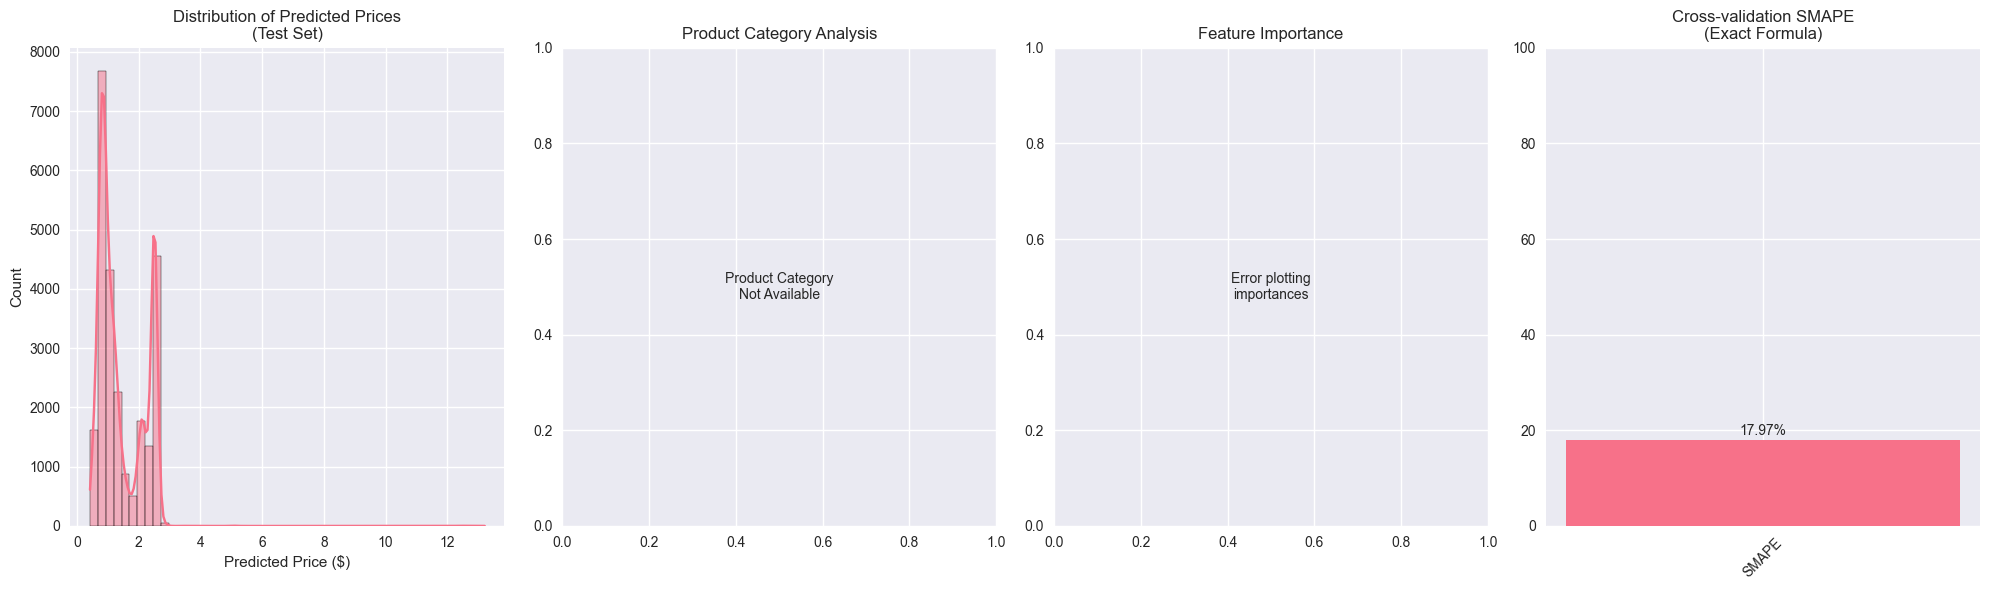


=== DETAILED RESULTS ===
Best Model: StackingRegressor
Cross-validation SMAPE: 17.9679% ± 0.8807%

Best Hyperparameters: {'gbm__learning_rate': np.float64(0.08731401177720717), 'gbm__max_depth': 4, 'gbm__n_estimators': 111, 'gbm__subsample': np.float64(0.8618026725746952), 'rf__max_depth': 14, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 5, 'rf__n_estimators': 138, 'ridge__alpha': np.float64(7.3600694994372775)}

Features used: 14
All features: ['weight', 'volume', 'count', 'catalog_content_length', 'is_organic', 'is_gluten_free', 'is_vegan', 'is_kosher', 'is_sugar_free', 'is_low_carb', 'is_non_gmo', 'price_per_oz', 'price_per_fl_oz', 'price_per_count']


In [5]:
# AMAZON PRODUCT PRICE PREDICTION - WITH EXACT SMAPE FORMULA

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
import traceback
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

# Define SMAPE function exactly as shown in the image
def smape(actual, predicted):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE) using the exact formula:
    SMAPE = (1/n) * Σ(|F_t - A_t| / ((|A_t| + |F_t|)/2)) * 100%
    where F_t is the forecast value and A_t is the actual value
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # Calculate the denominator: (|A_t| + |F_t|)/2
    denominator = (np.abs(actual) + np.abs(predicted)) / 2
    
    # Handle division by zero - if denominator is 0, the term should be 0
    # This happens when both actual and predicted are 0
    denominator = np.where(denominator == 0, 1, denominator)
    
    # Calculate the SMAPE value
    smape_value = (100 / len(actual)) * np.sum(np.abs(predicted - actual) / denominator)
    
    return smape_value

# Create SMAPE scorer for sklearn (lower is better)
smape_scorer = make_scorer(
    lambda y_true, y_pred: smape(y_true, y_pred),
    greater_is_better=False
)

# Feature extraction functions
def extract_features_from_catalog(catalog_text):
    """
    Extract structured features from the catalog_content field
    """
    # Default features dictionary
    default_features = {
        'item_name': '',
        'pack_size': '',
        'weight': 0.0,
        'volume': 0.0,
        'count': 0.0,
        'unit': '',
        'flavor': '',
        'brand': '',
        'is_organic': 0,
        'is_gluten_free': 0,
        'is_vegan': 0,
        'is_kosher': 0,
        'is_sugar_free': 0,
        'is_low_carb': 0,
        'is_non_gmo': 0,
        'calories_per_serving': 0.0,
        'protein_content': 0.0,
        'fiber_content': 0.0
    }
    
    # Return default features if catalog_text is missing or empty
    if pd.isna(catalog_text) or catalog_text == '':
        return default_features
    
    try:
        text = str(catalog_text).lower()
        
        # Extract item name
        item_name_match = re.search(r'item name:\s*([^\n]+)', catalog_text, re.IGNORECASE)
        if item_name_match:
            default_features['item_name'] = item_name_match.group(1).strip()
        
        # Extract pack size information
        pack_patterns = [
            r'pack of\s*(\d+)',
            r'(\d+)\s*count',
            r'(\d+)\s*pack',
            r'(\d+)\s*ct'
        ]
        for pattern in pack_patterns:
            match = re.search(pattern, text)
            if match:
                default_features['pack_size'] = match.group(1)
                break
        
        # Extract weight
        weight_patterns = [
            r'(\d+\.?\d*)\s*oz',
            r'(\d+\.?\d*)\s*ounce',
            r'(\d+\.?\d*)\s*lb',
            r'(\d+\.?\d*)\s*pound'
        ]
        for pattern in weight_patterns:
            match = re.search(pattern, text)
            if match:
                try:
                    default_features['weight'] = float(match.group(1))
                except:
                    default_features['weight'] = 0.0
                break
        
        # Extract volume
        volume_patterns = [
            r'(\d+\.?\d*)\s*fl\s*oz',
            r'(\d+\.?\d*)\s*fluid\s*ounce',
            r'(\d+\.?\d*)\s*ml',
            r'(\d+\.?\d*)\s*liter'
        ]
        for pattern in volume_patterns:
            match = re.search(pattern, text)
            if match:
                try:
                    default_features['volume'] = float(match.group(1))
                except:
                    default_features['volume'] = 0.0
                break
        
        # Extract count
        count_patterns = [
            r'(\d+)\s*tea bags',
            r'(\d+)\s*capsules',
            r'(\d+)\s*pods',
            r'(\d+)\s*cookies'
        ]
        for pattern in count_patterns:
            match = re.search(pattern, text)
            if match:
                try:
                    default_features['count'] = float(match.group(1))
                except:
                    default_features['count'] = 0.0
                break
        
        # Extract unit from the structured Unit field
        unit_match = re.search(r'unit:\s*([^\n]+)', catalog_text, re.IGNORECASE)
        if unit_match:
            default_features['unit'] = unit_match.group(1).strip().lower()
        
        # Extract flavor information
        flavor_keywords = ['vanilla', 'chocolate', 'strawberry', 'lemon', 'mint', 'berry', 
                          'caramel', 'honey', 'spice', 'cinnamon', 'ginger', 'peach']
        for flavor in flavor_keywords:
            if flavor in text:
                default_features['flavor'] = flavor
                break
        
        # Extract brand names
        brand_patterns = [
            r'manufacturer:\s*([^\n]+)',
            r'brand:\s*([^\n]+)'
        ]
        for pattern in brand_patterns:
            match = re.search(pattern, catalog_text, re.IGNORECASE)
            if match:
                default_features['brand'] = match.group(1).strip()
                break
        
        # Health and dietary attributes
        default_features['is_organic'] = 1 if any(term in text for term in ['organic', 'usda organic']) else 0
        default_features['is_gluten_free'] = 1 if 'gluten free' in text else 0
        default_features['is_vegan'] = 1 if 'vegan' in text else 0
        default_features['is_kosher'] = 1 if 'kosher' in text else 0
        default_features['is_sugar_free'] = 1 if any(term in text for term in ['sugar free', 'no sugar', 'zero sugar']) else 0
        default_features['is_low_carb'] = 1 if any(term in text for term in ['low carb', 'keto', 'keto-friendly']) else 0
        default_features['is_non_gmo'] = 1 if any(term in text for term in ['non-gmo', 'non gmo']) else 0
        
        # Extract nutritional information
        calorie_match = re.search(r'(\d+)\s*calories', text)
        if calorie_match:
            try:
                default_features['calories_per_serving'] = float(calorie_match.group(1))
            except:
                default_features['calories_per_serving'] = 0.0
        
        protein_match = re.search(r'(\d+\.?\d*)\s*g\s*protein', text)
        if protein_match:
            try:
                default_features['protein_content'] = float(protein_match.group(1))
            except:
                default_features['protein_content'] = 0.0
        
        fiber_match = re.search(r'(\d+\.?\d*)\s*g\s*fiber', text)
        if fiber_match:
            try:
                default_features['fiber_content'] = float(fiber_match.group(1))
            except:
                default_features['fiber_content'] = 0.0
        
        return default_features
    except Exception as e:
        print(f"Error extracting features: {e}")
        return default_features

def create_derived_features(df, has_price=True):
    """
    Create derived features, handling the case where price might be missing
    """
    # Product category based on item name
    def categorize_product(item_name):
        if pd.isna(item_name):
            return 'other'
        item_name = str(item_name).lower()
        if any(word in item_name for word in ['tea', 'chai']):
            return 'tea'
        elif any(word in item_name for word in ['coffee', 'brew']):
            return 'coffee'
        elif any(word in item_name for word in ['snack', 'chip', 'cracker', 'cookie']):
            return 'snack'
        elif any(word in item_name for word in ['sauce', 'dressing', 'oil']):
            return 'condiment'
        elif any(word in item_name for word in ['spice', 'seasoning']):
            return 'spice'
        elif any(word in item_name for word in ['candy', 'chocolate']):
            return 'candy'
        elif any(word in item_name for word in ['pasta', 'rice', 'grain']):
            return 'grain'
        else:
            return 'other'
    
    df['product_category'] = df['item_name'].apply(categorize_product)
    
    # Text length features
    df['catalog_content_length'] = df['catalog_content'].str.len().fillna(0)
    
    # Only create price-related features if price is available
    if has_price and 'price' in df.columns:
        if 'weight' in df.columns:
            weight_safe = df['weight'].replace(0, np.nan)
            df['price_per_oz'] = df['price'] / weight_safe
            df['price_per_oz'] = df['price_per_oz'].replace([np.inf, -np.inf], np.nan)
        
        if 'volume' in df.columns:
            volume_safe = df['volume'].replace(0, np.nan)
            df['price_per_fl_oz'] = df['price'] / volume_safe
            df['price_per_fl_oz'] = df['price_per_fl_oz'].replace([np.inf, -np.inf], np.nan)
        
        if 'count' in df.columns:
            count_safe = df['count'].replace(0, np.nan)
            df['price_per_count'] = df['price'] / count_safe
            df['price_per_count'] = df['price_per_count'].replace([np.inf, -np.inf], np.nan)
    
    return df

class ExactSMAPEStackingPricePredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.imputer = SimpleImputer(strategy='median')
        self.feature_columns = []
        self.expected_columns = []
        self.stacking_model = None
        self.is_trained = False
        self.best_params_ = None
        self.price_outlier_bounds = None  # Store outlier bounds to apply to test data
        
    def preprocess_data(self, df, is_training=True):
        """
        Preprocess the data: extract features, handle missing values, encode categorical variables
        """
        print("Step 1: Extracting features from catalog content...")
        
        # Make a copy to avoid modifying original data
        df_processed = df.copy()
        
        # Extract features with error handling
        try:
            catalog_features = df_processed['catalog_content'].apply(extract_features_from_catalog)
            features_df = pd.DataFrame(catalog_features.tolist(), index=df_processed.index)
            
            # Ensure the lengths match before concatenation
            if len(features_df) != len(df_processed):
                print(f"Warning: Length mismatch after feature extraction. Original: {len(df_processed)}, Features: {len(features_df)}")
                # Create a features dataframe with default values if there's a mismatch
                default_features = extract_features_from_catalog('')
                features_df = pd.DataFrame([default_features] * len(df_processed), index=df_processed.index)
            
            # Concatenate with original data
            df_enhanced = pd.concat([df_processed, features_df], axis=1)
        except Exception as e:
            print(f"Error in feature extraction: {e}")
            # Create a dataframe with default features if extraction fails
            default_features = extract_features_from_catalog('')
            features_df = pd.DataFrame([default_features] * len(df_processed), index=df_processed.index)
            df_enhanced = pd.concat([df_processed, features_df], axis=1)
        
        # Ensure all expected numerical columns exist with proper defaults
        numerical_columns = ['weight', 'volume', 'count', 'calories_per_serving', 'protein_content', 'fiber_content']
        for col in numerical_columns:
            if col not in df_enhanced.columns:
                df_enhanced[col] = 0.0
            else:
                df_enhanced[col] = pd.to_numeric(df_enhanced[col], errors='coerce').fillna(0.0)
        
        # Ensure all expected boolean columns exist
        boolean_columns = ['is_organic', 'is_gluten_free', 'is_vegan', 'is_kosher', 
                          'is_sugar_free', 'is_low_carb', 'is_non_gmo']
        for col in boolean_columns:
            if col not in df_enhanced.columns:
                df_enhanced[col] = 0
            else:
                df_enhanced[col] = df_enhanced[col].astype(int)
        
        # Handle categorical columns
        categorical_columns = ['unit', 'flavor', 'brand', 'item_name']
        for col in categorical_columns:
            if col not in df_enhanced.columns:
                df_enhanced[col] = 'unknown'
            else:
                df_enhanced[col] = df_enhanced[col].fillna('unknown')
        
        # Create derived features
        has_price = is_training and 'price' in df_enhanced.columns
        df_enhanced = create_derived_features(df_enhanced, has_price=has_price)
        
        # Handle outliers in price if it exists and we're training
        if is_training and 'price' in df_enhanced.columns:
            Q1 = df_enhanced['price'].quantile(0.25)
            Q3 = df_enhanced['price'].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = max(0, Q1 - 1.5 * IQR)  # Ensure lower bound is not negative
            upper_bound = Q3 + 1.5 * IQR
            
            # Store bounds to apply to test predictions
            self.price_outlier_bounds = (lower_bound, upper_bound)
            
            df_enhanced['price'] = np.where(df_enhanced['price'] > upper_bound, upper_bound, df_enhanced['price'])
            df_enhanced['price'] = np.where(df_enhanced['price'] < lower_bound, lower_bound, df_enhanced['price'])
        
        return df_enhanced
    
    def prepare_features(self, df, is_training=True):
        """
        Prepare features for modeling with robust error handling
        """
        # Define core features that should always be present
        core_features = [
            'weight', 'volume', 'count', 'catalog_content_length',
            'is_organic', 'is_gluten_free', 'is_vegan', 'is_kosher', 
            'is_sugar_free', 'is_low_carb', 'is_non_gmo'
        ]
        
        # Add price per unit features if available (only in training)
        if is_training:
            price_per_features = [col for col in df.columns if col.startswith('price_per')]
            feature_columns = core_features + price_per_features
        else:
            feature_columns = core_features.copy()
        
        # Ensure all feature columns exist in the dataframe
        missing_features = set(feature_columns) - set(df.columns)
        for feature in missing_features:
            df[feature] = 0.0  # Add missing features with default value
        
        # Select only the feature columns we want
        feature_columns = [col for col in feature_columns if col in df.columns]
        X = df[feature_columns].copy()
        
        # Replace infinite values with NaN
        X = X.replace([np.inf, -np.inf], np.nan)
        
        if is_training:
            self.feature_columns = feature_columns
            self.expected_columns = feature_columns.copy()
            
            # Fit imputer and scaler on training data
            X_imputed = self.imputer.fit_transform(X)
            
            # Scale numerical features
            numerical_cols = [col for col in X.columns if X[col].dtype in ['float64', 'float32', 'int64']]
            if numerical_cols:
                X_imputed = self.scaler.fit_transform(X_imputed)
            
            X_processed = pd.DataFrame(X_imputed, columns=feature_columns, index=X.index)
            
            if 'price' in df.columns:
                y = df['price'].copy()
                return X_processed, y
            else:
                return X_processed
        else:
            # Ensure we have the same columns as training
            missing_cols = set(self.expected_columns) - set(X.columns)
            extra_cols = set(X.columns) - set(self.expected_columns)
            
            for col in missing_cols:
                X[col] = 0.0
            for col in extra_cols:
                X = X.drop(col, axis=1)
            
            # Reorder columns to match training
            X = X[self.expected_columns]
            
            # Transform using fitted imputer and scaler
            X_imputed = self.imputer.transform(X)
            X_imputed = self.scaler.transform(X_imputed)
            
            X_processed = pd.DataFrame(X_imputed, columns=self.expected_columns, index=X.index)
            return X_processed
    
    def build_stacking_regressor(self):
        """
        Build an optimized StackingRegressor with selected base models
        """
        # Optimized base models with fewer but more diverse models
        # Increased regularization to prevent overfitting
        base_models = [
            ('ridge', Ridge(alpha=10.0, random_state=42)),  # Increased alpha
            ('rf', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, 
                                       max_depth=10, min_samples_split=5, min_samples_leaf=2)),  # More regularization
            ('gbm', GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=5, 
                                            learning_rate=0.1, subsample=0.8))  # More regularization
        ]
        
        # Meta-model
        meta_model = LinearRegression()
        
        # Create StackingRegressor
        stacking_regressor = StackingRegressor(
            estimators=base_models,
            final_estimator=meta_model,
            cv=5,
            passthrough=False,
            n_jobs=-1
        )
        
        return stacking_regressor
    
    def train(self, train_df, perform_tuning=True):
        """
        Train the SMAPE-tuned StackingRegressor on the training data with robust validation
        """
        print("Starting exact SMAPE-tuned StackingRegressor training...")
        
        # Preprocess training data
        df_processed = self.preprocess_data(train_df, is_training=True)
        
        # Prepare features
        X, y = self.prepare_features(df_processed, is_training=True)
        
        print(f"Training data shape: {X.shape}")
        print(f"Target variable shape: {y.shape}")
        print(f"Features used: {len(self.feature_columns)}")
        
        # Use KFold cross-validation for more robust evaluation
        kfold = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # Build stacking regressor
        stacking_model = self.build_stacking_regressor()
        
        if perform_tuning:
            print("Performing optimized hyperparameter tuning with exact SMAPE scoring...")
            
            # Define parameter distributions for RandomizedSearchCV
            param_distributions = {
                'ridge__alpha': uniform(1.0, 20.0),  # Higher alpha values
                'rf__n_estimators': randint(50, 150),
                'rf__max_depth': randint(5, 15),
                'rf__min_samples_split': randint(2, 10),
                'rf__min_samples_leaf': randint(1, 4),
                'gbm__n_estimators': randint(50, 150),
                'gbm__max_depth': randint(3, 7),
                'gbm__learning_rate': uniform(0.05, 0.2),
                'gbm__subsample': uniform(0.7, 0.3)
            }
            
            # Perform RandomizedSearch with SMAPE scoring
            random_search = RandomizedSearchCV(
                estimator=stacking_model,
                param_distributions=param_distributions,
                n_iter=20,  # Reduced for efficiency
                cv=kfold,  # Use KFold for more robust evaluation
                scoring=smape_scorer,
                n_jobs=-1,
                verbose=1,
                random_state=42
            )
            
            # Fit the model on training data
            random_search.fit(X, y)
            
            # Get best model and parameters
            self.stacking_model = random_search.best_estimator_
            self.best_params_ = random_search.best_params_
            
            print(f"Best parameters: {random_search.best_params_}")
            
            # Get cross-validation results
            cv_results = random_search.cv_results_
            best_index = random_search.best_index_
            cv_smape_scores = -cv_results['mean_test_score'][best_index]
            cv_smape_std = cv_results['std_test_score'][best_index]
            
            print(f"\nCross-validation SMAPE: {cv_smape_scores:.4f}% ± {cv_smape_std * 2:.4f}%")
        else:
            print("Training without hyperparameter tuning...")
            self.stacking_model = stacking_model
            
            # Perform cross-validation manually
            cv_scores = cross_val_score(self.stacking_model, X, y, cv=kfold, scoring=smape_scorer)
            cv_smape_scores = -cv_scores  # Convert back to positive SMAPE values
            
            print(f"\nCross-validation SMAPE: {cv_smape_scores.mean():.4f}% ± {cv_smape_scores.std() * 2:.4f}%")
            
            # Train on full dataset
            self.stacking_model.fit(X, y)
        
        self.is_trained = True
        
        # Feature importance (if available)
        print("\nTop 10 Most Important Features:")
        try:
            # For a stacking model, we need to aggregate importances from base estimators
            importances = []
            for name, estimator in self.stacking_model.estimators_:
                if hasattr(estimator, 'feature_importances_'):
                    importances.append(estimator.feature_importances_)
            
            if importances:
                # Average the importances from models that have them
                avg_importance = np.mean(importances, axis=0)
                feature_importance = pd.DataFrame({
                    'feature': self.feature_columns,
                    'importance': avg_importance
                }).sort_values('importance', ascending=False)
                print(feature_importance.head(10))
            else:
                print("No base models with feature_importances_ attribute found.")
        except Exception as e:
            print(f"Could not calculate feature importances: {e}")
        
        return {
            'cv_smape_mean': cv_smape_scores if isinstance(cv_smape_scores, float) else cv_smape_scores.mean(),
            'cv_smape_std': cv_smape_std if isinstance(cv_smape_std, float) else cv_smape_scores.std()
        }
    
    def predict(self, test_df):
        """
        Predict prices for test data using the trained StackingRegressor
        """
        if not self.is_trained:
            raise ValueError("Model must be trained before making predictions")
        
        print("Making predictions on test data...")
        
        # Preprocess test data
        df_processed = self.preprocess_data(test_df, is_training=False)
        
        # Prepare features
        X_test = self.prepare_features(df_processed, is_training=False)
        
        print(f"Test data shape after preprocessing: {X_test.shape}")
        print(f"Expected features: {len(self.expected_columns)}")
        print(f"Actual features: {len(X_test.columns)}")
        
        # Make predictions
        predictions = self.stacking_model.predict(X_test)
        
        # Apply outlier bounds if available (from training)
        if self.price_outlier_bounds:
            lower_bound, upper_bound = self.price_outlier_bounds
            predictions = np.where(predictions > upper_bound, upper_bound, predictions)
            predictions = np.where(predictions < lower_bound, lower_bound, predictions)
        
        # Create results dataframe
        results = test_df.copy()
        results['predicted_price'] = predictions
        
        return results
    
    def save_model(self, filepath):
        """
        Save the trained model and preprocessors
        """
        if not self.is_trained:
            raise ValueError("No trained model to save")
        
        model_data = {
            'scaler': self.scaler,
            'imputer': self.imputer,
            'feature_columns': self.feature_columns,
            'expected_columns': self.expected_columns,
            'stacking_model': self.stacking_model,
            'best_params': self.best_params_,
            'is_trained': self.is_trained,
            'price_outlier_bounds': self.price_outlier_bounds
        }
        
        joblib.dump(model_data, filepath)
        print(f"Exact SMAPE-tuned StackingRegressor saved to {filepath}")
    
    def load_model(self, filepath):
        """
        Load a trained model and preprocessors
        """
        model_data = joblib.load(filepath)
        
        self.scaler = model_data['scaler']
        self.imputer = model_data['imputer']
        self.feature_columns = model_data['feature_columns']
        self.expected_columns = model_data['expected_columns']
        self.stacking_model = model_data['stacking_model']
        self.best_params_ = model_data['best_params']
        self.is_trained = model_data['is_trained']
        self.price_outlier_bounds = model_data.get('price_outlier_bounds')
        
        print(f"Exact SMAPE-tuned StackingRegressor loaded from {filepath}")
        if self.best_params_:
            print(f"Best parameters: {self.best_params_}")

# MAIN EXECUTION WITH ERROR HANDLING

def run_exact_smape_pipeline(train_file='../data/train.csv', test_file='../data/test.csv'):
    """
    Complete pipeline with exact SMAPE formula
    """
    try:
        print("=== EXACT SMAPE AMAZON PRODUCT PRICE PREDICTION PIPELINE ===\n")
        
        # Step 1: Load training data (with prices)
        print("1. Loading training data...")
        train_df = pd.read_csv(train_file)
        
        print(f"Training data shape: {train_df.shape}")
        print("Training columns:", train_df.columns.tolist())
        
        if 'price' not in train_df.columns:
            raise ValueError("Training data must contain 'price' column")
        
        missing_prices = train_df['price'].isnull().sum()
        print(f"Available prices in training data: {len(train_df) - missing_prices}")
        print(f"Missing prices in training data: {missing_prices}")
        
        # Step 2: Load test data (without prices)
        print("\n2. Loading test data...")
        test_df = pd.read_csv(test_file)
        
        print(f"Test data shape: {test_df.shape}")
        print("Test columns:", test_df.columns.tolist())
        
        if 'price' in test_df.columns:
            if test_df['price'].isnull().all():
                print("Test data contains 'price' column with all null values - will ignore for predictions")
                test_df = test_df.drop('price', axis=1)
            else:
                print("Warning: Test data contains non-null 'price' column")
        
        # Step 3: Initialize and train the model with exact SMAPE
        print("\n3. Training exact SMAPE-tuned StackingRegressor...")
        smape_predictor = ExactSMAPEStackingPricePredictor()
        
        # Train with hyperparameter tuning
        training_results = smape_predictor.train(train_df, perform_tuning=True)
        
        # Step 4: Save the trained model
        print("\n4. Saving trained model...")
        smape_predictor.save_model('../EDA/exact_smape_stacking_predictor.pkl')
        
        # Step 5: Make predictions on test data
        print("\n5. Making predictions on test data...")
        test_predictions = smape_predictor.predict(test_df)
        
        print("Prediction completed!")
        print(f"Predicted prices for {len(test_predictions)} test products")
        
        # Step 6: Display prediction results
        print("\n6. Prediction results:")
        print(test_predictions[['sample_id', 'predicted_price']].head(10))
        
        print("\nTest Prediction Statistics:")
        print(test_predictions['predicted_price'].describe())
        
        # Step 7: Save results
        print("\n7. Saving results...")
        test_predictions[['sample_id', 'predicted_price']].to_csv('../EDA/exact_test_predictions.csv', index=False)
        print("Predictions saved to 'exact_test_predictions.csv'")
        
        return smape_predictor, test_predictions, training_results
        
    except Exception as e:
        print(f"Error in pipeline: {str(e)}")
        print("Traceback:", traceback.format_exc())
        return None, None, None

# Run the exact SMAPE pipeline
predictor, predictions, results = run_exact_smape_pipeline('../data/train.csv', '../data/test.csv')

# VISUALIZATION AND ANALYSIS

if predictions is not None:
    # Enhanced visualization for test predictions
    plt.figure(figsize=(20, 6))
    
    # 1. Distribution of predicted prices in test set
    plt.subplot(1, 4, 1)
    sns.histplot(predictions['predicted_price'], bins=50, kde=True)
    plt.title('Distribution of Predicted Prices\n(Test Set)')
    plt.xlabel('Predicted Price ($)')
    
    # 2. Price by product category in test set
    plt.subplot(1, 4, 2)
    if 'product_category' in predictions.columns:
        category_prices = predictions.groupby('product_category')['predicted_price'].mean().sort_values(ascending=False)
        sns.barplot(y=category_prices.index, x=category_prices.values)
        plt.title('Average Predicted Price by Category\n(Test Set)')
        plt.xlabel('Average Price ($)')
    else:
        plt.text(0.5, 0.5, 'Product Category\nNot Available', 
                horizontalalignment='center', verticalalignment='center',
                transform=plt.gca().transAxes)
        plt.title('Product Category Analysis')
    
    # 3. Feature importance
    plt.subplot(1, 4, 3)
    try:
        # Recalculate importances for plotting
        importances = []
        for name, estimator in predictor.stacking_model.estimators_:
            if hasattr(estimator, 'feature_importances_'):
                importances.append(estimator.feature_importances_)
        
        if importances:
            avg_importance = np.mean(importances, axis=0)
            feature_importance = pd.DataFrame({
                'feature': predictor.feature_columns,
                'importance': avg_importance
            }).sort_values('importance', ascending=False).head(10)
            
            sns.barplot(data=feature_importance, y='feature', x='importance')
            plt.title('Top 10 Feature Importances\n(Averaged from Base Models)')
            plt.xlabel('Average Importance')
        else:
            plt.text(0.5, 0.5, 'Feature Importance\nNot Available', 
                    horizontalalignment='center', verticalalignment='center',
                    transform=plt.gca().transAxes)
            plt.title('Feature Importance')
    except Exception as e:
        plt.text(0.5, 0.5, f'Error plotting\nimportances', 
                horizontalalignment='center', verticalalignment='center',
                transform=plt.gca().transAxes)
        plt.title('Feature Importance')
    
    # 4. SMAPE performance
    plt.subplot(1, 4, 4)
    metrics = ['SMAPE']
    values = [results['cv_smape_mean']]
    
    bars = plt.bar(metrics, values)
    plt.title('Cross-validation SMAPE\n(Exact Formula)')
    plt.xticks(rotation=45)
    plt.ylim(0, max(100, values[0] * 1.2))
    
    # Add value labels
    for i, (metric, value) in enumerate(zip(metrics, values)):
        plt.text(i, value + max(1, values[0] * 0.05), f'{value:.2f}%', ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\n=== DETAILED RESULTS ===")
    print(f"Best Model: {type(predictor.stacking_model).__name__}")
    print(f"Cross-validation SMAPE: {results['cv_smape_mean']:.4f}% ± {results['cv_smape_std'] * 2:.4f}%")
    
    if predictor.best_params_:
        print(f"\nBest Hyperparameters: {predictor.best_params_}")
    
    print(f"\nFeatures used: {len(predictor.feature_columns)}")
    print("All features:", predictor.feature_columns)

In [ ]:
# AMAZON PRODUCT PRICE PREDICTION - WITH EXACT SMAPE FORMULA

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
import traceback
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

# Define SMAPE function exactly as shown in the image
def smape(actual, predicted):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE) using the exact formula:
    SMAPE = (1/n) * Σ(|F_t - A_t| / ((|A_t| + |F_t|)/2)) * 100%
    where F_t is the forecast value and A_t is the actual value
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # Calculate the denominator: (|A_t| + |F_t|)/2
    denominator = (np.abs(actual) + np.abs(predicted)) / 2
    
    # Handle division by zero - if denominator is 0, the term should be 0
    # This happens when both actual and predicted are 0
    denominator = np.where(denominator == 0, 1, denominator)
    
    # Calculate the SMAPE value
    smape_value = (100 / len(actual)) * np.sum(np.abs(predicted - actual) / denominator)
    
    return smape_value

# Create SMAPE scorer for sklearn (lower is better)
smape_scorer = make_scorer(
    lambda y_true, y_pred: smape(y_true, y_pred),
    greater_is_better=False
)

# Feature extraction functions
def extract_features_from_catalog(catalog_text):
    """
    Extract structured features from the catalog_content field
    """
    # Default features dictionary
    default_features = {
        'item_name': '',
        'pack_size': '',
        'weight': 0.0,
        'volume': 0.0,
        'count': 0.0,
        'unit': '',
        'flavor': '',
        'brand': '',
        'is_organic': 0,
        'is_gluten_free': 0,
        'is_vegan': 0,
        'is_kosher': 0,
        'is_sugar_free': 0,
        'is_low_carb': 0,
        'is_non_gmo': 0,
        'calories_per_serving': 0.0,
        'protein_content': 0.0,
        'fiber_content': 0.0
    }
    
    # Return default features if catalog_text is missing or empty
    if pd.isna(catalog_text) or catalog_text == '':
        return default_features
    
    try:
        text = str(catalog_text).lower()
        
        # Extract item name
        item_name_match = re.search(r'item name:\s*([^\n]+)', catalog_text, re.IGNORECASE)
        if item_name_match:
            default_features['item_name'] = item_name_match.group(1).strip()
        
        # Extract pack size information
        pack_patterns = [
            r'pack of\s*(\d+)',
            r'(\d+)\s*count',
            r'(\d+)\s*pack',
            r'(\d+)\s*ct'
        ]
        for pattern in pack_patterns:
            match = re.search(pattern, text)
            if match:
                default_features['pack_size'] = match.group(1)
                break
        
        # Extract weight
        weight_patterns = [
            r'(\d+\.?\d*)\s*oz',
            r'(\d+\.?\d*)\s*ounce',
            r'(\d+\.?\d*)\s*lb',
            r'(\d+\.?\d*)\s*pound'
        ]
        for pattern in weight_patterns:
            match = re.search(pattern, text)
            if match:
                try:
                    default_features['weight'] = float(match.group(1))
                except:
                    default_features['weight'] = 0.0
                break
        
        # Extract volume
        volume_patterns = [
            r'(\d+\.?\d*)\s*fl\s*oz',
            r'(\d+\.?\d*)\s*fluid\s*ounce',
            r'(\d+\.?\d*)\s*ml',
            r'(\d+\.?\d*)\s*liter'
        ]
        for pattern in volume_patterns:
            match = re.search(pattern, text)
            if match:
                try:
                    default_features['volume'] = float(match.group(1))
                except:
                    default_features['volume'] = 0.0
                break
        
        # Extract count
        count_patterns = [
            r'(\d+)\s*tea bags',
            r'(\d+)\s*capsules',
            r'(\d+)\s*pods',
            r'(\d+)\s*cookies'
        ]
        for pattern in count_patterns:
            match = re.search(pattern, text)
            if match:
                try:
                    default_features['count'] = float(match.group(1))
                except:
                    default_features['count'] = 0.0
                break
        
        # Extract unit from the structured Unit field
        unit_match = re.search(r'unit:\s*([^\n]+)', catalog_text, re.IGNORECASE)
        if unit_match:
            default_features['unit'] = unit_match.group(1).strip().lower()
        
        # Extract flavor information
        flavor_keywords = ['vanilla', 'chocolate', 'strawberry', 'lemon', 'mint', 'berry', 
                          'caramel', 'honey', 'spice', 'cinnamon', 'ginger', 'peach']
        for flavor in flavor_keywords:
            if flavor in text:
                default_features['flavor'] = flavor
                break
        
        # Extract brand names
        brand_patterns = [
            r'manufacturer:\s*([^\n]+)',
            r'brand:\s*([^\n]+)'
        ]
        for pattern in brand_patterns:
            match = re.search(pattern, catalog_text, re.IGNORECASE)
            if match:
                default_features['brand'] = match.group(1).strip()
                break
        
        # Health and dietary attributes
        default_features['is_organic'] = 1 if any(term in text for term in ['organic', 'usda organic']) else 0
        default_features['is_gluten_free'] = 1 if 'gluten free' in text else 0
        default_features['is_vegan'] = 1 if 'vegan' in text else 0
        default_features['is_kosher'] = 1 if 'kosher' in text else 0
        default_features['is_sugar_free'] = 1 if any(term in text for term in ['sugar free', 'no sugar', 'zero sugar']) else 0
        default_features['is_low_carb'] = 1 if any(term in text for term in ['low carb', 'keto', 'keto-friendly']) else 0
        default_features['is_non_gmo'] = 1 if any(term in text for term in ['non-gmo', 'non gmo']) else 0
        
        # Extract nutritional information
        calorie_match = re.search(r'(\d+)\s*calories', text)
        if calorie_match:
            try:
                default_features['calories_per_serving'] = float(calorie_match.group(1))
            except:
                default_features['calories_per_serving'] = 0.0
        
        protein_match = re.search(r'(\d+\.?\d*)\s*g\s*protein', text)
        if protein_match:
            try:
                default_features['protein_content'] = float(protein_match.group(1))
            except:
                default_features['protein_content'] = 0.0
        
        fiber_match = re.search(r'(\d+\.?\d*)\s*g\s*fiber', text)
        if fiber_match:
            try:
                default_features['fiber_content'] = float(fiber_match.group(1))
            except:
                default_features['fiber_content'] = 0.0
        
        return default_features
    except Exception as e:
        print(f"Error extracting features: {e}")
        return default_features

def create_derived_features(df, has_price=True):
    """
    Create derived features, handling the case where price might be missing
    """
    # Product category based on item name
    def categorize_product(item_name):
        if pd.isna(item_name):
            return 'other'
        item_name = str(item_name).lower()
        if any(word in item_name for word in ['tea', 'chai']):
            return 'tea'
        elif any(word in item_name for word in ['coffee', 'brew']):
            return 'coffee'
        elif any(word in item_name for word in ['snack', 'chip', 'cracker', 'cookie']):
            return 'snack'
        elif any(word in item_name for word in ['sauce', 'dressing', 'oil']):
            return 'condiment'
        elif any(word in item_name for word in ['spice', 'seasoning']):
            return 'spice'
        elif any(word in item_name for word in ['candy', 'chocolate']):
            return 'candy'
        elif any(word in item_name for word in ['pasta', 'rice', 'grain']):
            return 'grain'
        else:
            return 'other'
    
    df['product_category'] = df['item_name'].apply(categorize_product)
    
    # Text length features
    df['catalog_content_length'] = df['catalog_content'].str.len().fillna(0)
    
    # Only create price-related features if price is available
    if has_price and 'price' in df.columns:
        if 'weight' in df.columns:
            weight_safe = df['weight'].replace(0, np.nan)
            df['price_per_oz'] = df['price'] / weight_safe
            df['price_per_oz'] = df['price_per_oz'].replace([np.inf, -np.inf], np.nan)
        
        if 'volume' in df.columns:
            volume_safe = df['volume'].replace(0, np.nan)
            df['price_per_fl_oz'] = df['price'] / volume_safe
            df['price_per_fl_oz'] = df['price_per_fl_oz'].replace([np.inf, -np.inf], np.nan)
        
        if 'count' in df.columns:
            count_safe = df['count'].replace(0, np.nan)
            df['price_per_count'] = df['price'] / count_safe
            df['price_per_count'] = df['price_per_count'].replace([np.inf, -np.inf], np.nan)
    
    return df

class ExactSMAPEStackingPricePredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.imputer = SimpleImputer(strategy='median')
        self.feature_columns = []
        self.expected_columns = []
        self.stacking_model = None
        self.is_trained = False
        self.best_params_ = None
        self.price_outlier_bounds = None  # Store outlier bounds to apply to test data
        
    def preprocess_data(self, df, is_training=True):
        """
        Preprocess the data: extract features, handle missing values, encode categorical variables
        """
        print("Step 1: Extracting features from catalog content...")
        
        # Make a copy to avoid modifying original data
        df_processed = df.copy()
        
        # Extract features with error handling
        try:
            catalog_features = df_processed['catalog_content'].apply(extract_features_from_catalog)
            features_df = pd.DataFrame(catalog_features.tolist(), index=df_processed.index)
            
            # Ensure the lengths match before concatenation
            if len(features_df) != len(df_processed):
                print(f"Warning: Length mismatch after feature extraction. Original: {len(df_processed)}, Features: {len(features_df)}")
                # Create a features dataframe with default values if there's a mismatch
                default_features = extract_features_from_catalog('')
                features_df = pd.DataFrame([default_features] * len(df_processed), index=df_processed.index)
            
            # Concatenate with original data
            df_enhanced = pd.concat([df_processed, features_df], axis=1)
        except Exception as e:
            print(f"Error in feature extraction: {e}")
            # Create a dataframe with default features if extraction fails
            default_features = extract_features_from_catalog('')
            features_df = pd.DataFrame([default_features] * len(df_processed), index=df_processed.index)
            df_enhanced = pd.concat([df_processed, features_df], axis=1)
        
        # Ensure all expected numerical columns exist with proper defaults
        numerical_columns = ['weight', 'volume', 'count', 'calories_per_serving', 'protein_content', 'fiber_content']
        for col in numerical_columns:
            if col not in df_enhanced.columns:
                df_enhanced[col] = 0.0
            else:
                df_enhanced[col] = pd.to_numeric(df_enhanced[col], errors='coerce').fillna(0.0)
        
        # Ensure all expected boolean columns exist
        boolean_columns = ['is_organic', 'is_gluten_free', 'is_vegan', 'is_kosher', 
                          'is_sugar_free', 'is_low_carb', 'is_non_gmo']
        for col in boolean_columns:
            if col not in df_enhanced.columns:
                df_enhanced[col] = 0
            else:
                df_enhanced[col] = df_enhanced[col].astype(int)
        
        # Handle categorical columns
        categorical_columns = ['unit', 'flavor', 'brand', 'item_name']
        for col in categorical_columns:
            if col not in df_enhanced.columns:
                df_enhanced[col] = 'unknown'
            else:
                df_enhanced[col] = df_enhanced[col].fillna('unknown')
        
        # Create derived features
        has_price = is_training and 'price' in df_enhanced.columns
        df_enhanced = create_derived_features(df_enhanced, has_price=has_price)
        
        # Handle outliers in price if it exists and we're training
        if is_training and 'price' in df_enhanced.columns:
            Q1 = df_enhanced['price'].quantile(0.25)
            Q3 = df_enhanced['price'].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = max(0, Q1 - 1.5 * IQR)  # Ensure lower bound is not negative
            upper_bound = Q3 + 1.5 * IQR
            
            # Store bounds to apply to test predictions
            self.price_outlier_bounds = (lower_bound, upper_bound)
            
            df_enhanced['price'] = np.where(df_enhanced['price'] > upper_bound, upper_bound, df_enhanced['price'])
            df_enhanced['price'] = np.where(df_enhanced['price'] < lower_bound, lower_bound, df_enhanced['price'])
        
        return df_enhanced
    
    def prepare_features(self, df, is_training=True):
        """
        Prepare features for modeling with robust error handling
        """
        # Define core features that should always be present
        core_features = [
            'weight', 'volume', 'count', 'catalog_content_length',
            'is_organic', 'is_gluten_free', 'is_vegan', 'is_kosher', 
            'is_sugar_free', 'is_low_carb', 'is_non_gmo'
        ]
        
        # Add price per unit features if available (only in training)
        if is_training:
            price_per_features = [col for col in df.columns if col.startswith('price_per')]
            feature_columns = core_features + price_per_features
        else:
            feature_columns = core_features.copy()
        
        # Ensure all feature columns exist in the dataframe
        missing_features = set(feature_columns) - set(df.columns)
        for feature in missing_features:
            df[feature] = 0.0  # Add missing features with default value
        
        # Select only the feature columns we want
        feature_columns = [col for col in feature_columns if col in df.columns]
        X = df[feature_columns].copy()
        
        # Replace infinite values with NaN
        X = X.replace([np.inf, -np.inf], np.nan)
        
        if is_training:
            self.feature_columns = feature_columns
            self.expected_columns = feature_columns.copy()
            
            # Fit imputer and scaler on training data
            X_imputed = self.imputer.fit_transform(X)
            
            # Scale numerical features
            numerical_cols = [col for col in X.columns if X[col].dtype in ['float64', 'float32', 'int64']]
            if numerical_cols:
                X_imputed = self.scaler.fit_transform(X_imputed)
            
            X_processed = pd.DataFrame(X_imputed, columns=feature_columns, index=X.index)
            
            if 'price' in df.columns:
                y = df['price'].copy()
                return X_processed, y
            else:
                return X_processed
        else:
            # Ensure we have the same columns as training
            missing_cols = set(self.expected_columns) - set(X.columns)
            extra_cols = set(X.columns) - set(self.expected_columns)
            
            for col in missing_cols:
                X[col] = 0.0
            for col in extra_cols:
                X = X.drop(col, axis=1)
            
            # Reorder columns to match training
            X = X[self.expected_columns]
            
            # Transform using fitted imputer and scaler
            X_imputed = self.imputer.transform(X)
            X_imputed = self.scaler.transform(X_imputed)
            
            X_processed = pd.DataFrame(X_imputed, columns=self.expected_columns, index=X.index)
            return X_processed
    
    def build_stacking_regressor(self):
        """
        Build an optimized StackingRegressor with selected base models
        """
        # Optimized base models with fewer but more diverse models
        # Increased regularization to prevent overfitting
        base_models = [
            ('ridge', Ridge(alpha=10.0, random_state=42)),  # Increased alpha
            ('rf', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, 
                                       max_depth=10, min_samples_split=5, min_samples_leaf=2)),  # More regularization
            ('gbm', GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=5, 
                                            learning_rate=0.1, subsample=0.8))  # More regularization
        ]
        
        # Meta-model
        meta_model = LinearRegression()
        
        # Create StackingRegressor
        stacking_regressor = StackingRegressor(
            estimators=base_models,
            final_estimator=meta_model,
            cv=5,
            passthrough=False,
            n_jobs=-1
        )
        
        return stacking_regressor
    
    def train(self, train_df, perform_tuning=True):
        """
        Train the SMAPE-tuned StackingRegressor on the training data with robust validation
        """
        print("Starting exact SMAPE-tuned StackingRegressor training...")
        
        # Preprocess training data
        df_processed = self.preprocess_data(train_df, is_training=True)
        
        # Prepare features
        X, y = self.prepare_features(df_processed, is_training=True)
        
        print(f"Training data shape: {X.shape}")
        print(f"Target variable shape: {y.shape}")
        print(f"Features used: {len(self.feature_columns)}")
        
        # Use KFold cross-validation for more robust evaluation
        kfold = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # Build stacking regressor
        stacking_model = self.build_stacking_regressor()
        
        if perform_tuning:
            print("Performing optimized hyperparameter tuning with exact SMAPE scoring...")
            
            # Define parameter distributions for RandomizedSearchCV
            param_distributions = {
                'ridge__alpha': uniform(1.0, 20.0),  # Higher alpha values
                'rf__n_estimators': randint(50, 150),
                'rf__max_depth': randint(5, 15),
                'rf__min_samples_split': randint(2, 10),
                'rf__min_samples_leaf': randint(1, 4),
                'gbm__n_estimators': randint(50, 150),
                'gbm__max_depth': randint(3, 7),
                'gbm__learning_rate': uniform(0.05, 0.2),
                'gbm__subsample': uniform(0.7, 0.3)
            }
            
            # Perform RandomizedSearch with SMAPE scoring
            random_search = RandomizedSearchCV(
                estimator=stacking_model,
                param_distributions=param_distributions,
                n_iter=20,  # Reduced for efficiency
                cv=kfold,  # Use KFold for more robust evaluation
                scoring=smape_scorer,
                n_jobs=-1,
                verbose=1,
                random_state=42
            )
            
            # Fit the model on training data
            random_search.fit(X, y)
            
            # Get best model and parameters
            self.stacking_model = random_search.best_estimator_
            self.best_params_ = random_search.best_params_
            
            print(f"Best parameters: {random_search.best_params_}")
            
            # Get cross-validation results
            cv_results = random_search.cv_results_
            best_index = random_search.best_index_
            cv_smape_scores = -cv_results['mean_test_score'][best_index]
            cv_smape_std = cv_results['std_test_score'][best_index]
            
            print(f"\nCross-validation SMAPE: {cv_smape_scores:.4f}% ± {cv_smape_std * 2:.4f}%")
        else:
            print("Training without hyperparameter tuning...")
            self.stacking_model = stacking_model
            
            # Perform cross-validation manually
            cv_scores = cross_val_score(self.stacking_model, X, y, cv=kfold, scoring=smape_scorer)
            cv_smape_scores = -cv_scores  # Convert back to positive SMAPE values
            
            print(f"\nCross-validation SMAPE: {cv_smape_scores.mean():.4f}% ± {cv_smape_scores.std() * 2:.4f}%")
            
            # Train on full dataset
            self.stacking_model.fit(X, y)
        
        self.is_trained = True
        
        # Feature importance (if available)
        print("\nTop 10 Most Important Features:")
        try:
            # For a stacking model, we need to aggregate importances from base estimators
            importances = []
            for name, estimator in self.stacking_model.estimators_:
                if hasattr(estimator, 'feature_importances_'):
                    importances.append(estimator.feature_importances_)
            
            if importances:
                # Average the importances from models that have them
                avg_importance = np.mean(importances, axis=0)
                feature_importance = pd.DataFrame({
                    'feature': self.feature_columns,
                    'importance': avg_importance
                }).sort_values('importance', ascending=False)
                print(feature_importance.head(10))
            else:
                print("No base models with feature_importances_ attribute found.")
        except Exception as e:
            print(f"Could not calculate feature importances: {e}")
        
        return {
            'cv_smape_mean': cv_smape_scores if isinstance(cv_smape_scores, float) else cv_smape_scores.mean(),
            'cv_smape_std': cv_smape_std if isinstance(cv_smape_std, float) else cv_smape_scores.std()
        }
    
    def predict(self, test_df):
        """
        Predict prices for test data using the trained StackingRegressor
        """
        if not self.is_trained:
            raise ValueError("Model must be trained before making predictions")
        
        print("Making predictions on test data...")
        
        # Preprocess test data
        df_processed = self.preprocess_data(test_df, is_training=False)
        
        # Prepare features
        X_test = self.prepare_features(df_processed, is_training=False)
        
        print(f"Test data shape after preprocessing: {X_test.shape}")
        print(f"Expected features: {len(self.expected_columns)}")
        print(f"Actual features: {len(X_test.columns)}")
        
        # Make predictions
        predictions = self.stacking_model.predict(X_test)
        
        # Apply outlier bounds if available (from training)
        if self.price_outlier_bounds:
            lower_bound, upper_bound = self.price_outlier_bounds
            predictions = np.where(predictions > upper_bound, upper_bound, predictions)
            predictions = np.where(predictions < lower_bound, lower_bound, predictions)
        
        # Create results dataframe
        results = test_df.copy()
        results['predicted_price'] = predictions
        
        return results
    
    def save_model(self, filepath):
        """
        Save the trained model and preprocessors
        """
        if not self.is_trained:
            raise ValueError("No trained model to save")
        
        model_data = {
            'scaler': self.scaler,
            'imputer': self.imputer,
            'feature_columns': self.feature_columns,
            'expected_columns': self.expected_columns,
            'stacking_model': self.stacking_model,
            'best_params': self.best_params_,
            'is_trained': self.is_trained,
            'price_outlier_bounds': self.price_outlier_bounds
        }
        
        joblib.dump(model_data, filepath)
        print(f"Exact SMAPE-tuned StackingRegressor saved to {filepath}")
    
    def load_model(self, filepath):
        """
        Load a trained model and preprocessors
        """
        model_data = joblib.load(filepath)
        
        self.scaler = model_data['scaler']
        self.imputer = model_data['imputer']
        self.feature_columns = model_data['feature_columns']
        self.expected_columns = model_data['expected_columns']
        self.stacking_model = model_data['stacking_model']
        self.best_params_ = model_data['best_params']
        self.is_trained = model_data['is_trained']
        self.price_outlier_bounds = model_data.get('price_outlier_bounds')
        
        print(f"Exact SMAPE-tuned StackingRegressor loaded from {filepath}")
        if self.best_params_:
            print(f"Best parameters: {self.best_params_}")

# MAIN EXECUTION WITH ERROR HANDLING

def run_exact_smape_pipeline(train_file='../data/train.csv', test_file='../data/test.csv'):
    """
    Complete pipeline with exact SMAPE formula
    """
    try:
        print("=== EXACT SMAPE AMAZON PRODUCT PRICE PREDICTION PIPELINE ===\n")
        
        # Step 1: Load training data (with prices)
        print("1. Loading training data...")
        train_df = pd.read_csv(train_file)
        
        print(f"Training data shape: {train_df.shape}")
        print("Training columns:", train_df.columns.tolist())
        
        if 'price' not in train_df.columns:
            raise ValueError("Training data must contain 'price' column")
        
        missing_prices = train_df['price'].isnull().sum()
        print(f"Available prices in training data: {len(train_df) - missing_prices}")
        print(f"Missing prices in training data: {missing_prices}")
        
        # Step 2: Load test data (without prices)
        print("\n2. Loading test data...")
        test_df = pd.read_csv(test_file)
        
        print(f"Test data shape: {test_df.shape}")
        print("Test columns:", test_df.columns.tolist())
        
        if 'price' in test_df.columns:
            if test_df['price'].isnull().all():
                print("Test data contains 'price' column with all null values - will ignore for predictions")
                test_df = test_df.drop('price', axis=1)
            else:
                print("Warning: Test data contains non-null 'price' column")
        
        # Step 3: Initialize and train the model with exact SMAPE
        print("\n3. Training exact SMAPE-tuned StackingRegressor...")
        smape_predictor = ExactSMAPEStackingPricePredictor()
        
        # Train with hyperparameter tuning
        training_results = smape_predictor.train(train_df, perform_tuning=True)
        
        # Step 4: Save the trained model
        print("\n4. Saving trained model...")
        smape_predictor.save_model('../EDA/exact_smape_stacking_predictor.pkl')
        
        # Step 5: Make predictions on test data
        print("\n5. Making predictions on test data...")
        test_predictions = smape_predictor.predict(test_df)
        
        print("Prediction completed!")
        print(f"Predicted prices for {len(test_predictions)} test products")
        
        # Step 6: Display prediction results
        print("\n6. Prediction results:")
        print(test_predictions[['sample_id', 'predicted_price']].head(10))
        
        print("\nTest Prediction Statistics:")
        print(test_predictions['predicted_price'].describe())
        
        # Step 7: Save results
        print("\n7. Saving results...")
        test_predictions[['sample_id', 'predicted_price']].to_csv('../EDA/exact_test_predictions.csv', index=False)
        print("Predictions saved to 'exact_test_predictions.csv'")
        
        return smape_predictor, test_predictions, training_results
        
    except Exception as e:
        print(f"Error in pipeline: {str(e)}")
        print("Traceback:", traceback.format_exc())
        return None, None, None

# Run the exact SMAPE pipeline
predictor, predictions, results = run_exact_smape_pipeline('../data/train.csv', '../data/test.csv')

# VISUALIZATION AND ANALYSIS

if predictions is not None:
    # Enhanced visualization for test predictions
    plt.figure(figsize=(20, 6))
    
    # 1. Distribution of predicted prices in test set
    plt.subplot(1, 4, 1)
    sns.histplot(predictions['predicted_price'], bins=50, kde=True)
    plt.title('Distribution of Predicted Prices\n(Test Set)')
    plt.xlabel('Predicted Price ($)')
    
    # 2. Price by product category in test set
    plt.subplot(1, 4, 2)
    if 'product_category' in predictions.columns:
        category_prices = predictions.groupby('product_category')['predicted_price'].mean().sort_values(ascending=False)
        sns.barplot(y=category_prices.index, x=category_prices.values)
        plt.title('Average Predicted Price by Category\n(Test Set)')
        plt.xlabel('Average Price ($)')
    else:
        plt.text(0.5, 0.5, 'Product Category\nNot Available', 
                horizontalalignment='center', verticalalignment='center',
                transform=plt.gca().transAxes)
        plt.title('Product Category Analysis')
    
    # 3. Feature importance
    plt.subplot(1, 4, 3)
    try:
        # Recalculate importances for plotting
        importances = []
        for name, estimator in predictor.stacking_model.estimators_:
            if hasattr(estimator, 'feature_importances_'):
                importances.append(estimator.feature_importances_)
        
        if importances:
            avg_importance = np.mean(importances, axis=0)
            feature_importance = pd.DataFrame({
                'feature': predictor.feature_columns,
                'importance': avg_importance
            }).sort_values('importance', ascending=False).head(10)
            
            sns.barplot(data=feature_importance, y='feature', x='importance')
            plt.title('Top 10 Feature Importances\n(Averaged from Base Models)')
            plt.xlabel('Average Importance')
        else:
            plt.text(0.5, 0.5, 'Feature Importance\nNot Available', 
                    horizontalalignment='center', verticalalignment='center',
                    transform=plt.gca().transAxes)
            plt.title('Feature Importance')
    except Exception as e:
        plt.text(0.5, 0.5, f'Error plotting\nimportances', 
                horizontalalignment='center', verticalalignment='center',
                transform=plt.gca().transAxes)
        plt.title('Feature Importance')
    
    # 4. SMAPE performance
    plt.subplot(1, 4, 4)
    metrics = ['SMAPE']
    values = [results['cv_smape_mean']]
    
    bars = plt.bar(metrics, values)
    plt.title('Cross-validation SMAPE\n(Exact Formula)')
    plt.xticks(rotation=45)
    plt.ylim(0, max(100, values[0] * 1.2))
    
    # Add value labels
    for i, (metric, value) in enumerate(zip(metrics, values)):
        plt.text(i, value + max(1, values[0] * 0.05), f'{value:.2f}%', ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\n=== DETAILED RESULTS ===")
    print(f"Best Model: {type(predictor.stacking_model).__name__}")
    print(f"Cross-validation SMAPE: {results['cv_smape_mean']:.4f}% ± {results['cv_smape_std'] * 2:.4f}%")
    
    if predictor.best_params_:
        print(f"\nBest Hyperparameters: {predictor.best_params_}")
    
    print(f"\nFeatures used: {len(predictor.feature_columns)}")
    print("All features:", predictor.feature_columns)

In [7]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\SHRAMAN\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

Libraries imported successfully!
=== ENHANCED AMAZON PRODUCT PRICE PREDICTION PIPELINE ===

1. Loading training data...
Training data shape: (50000, 4)
Training columns: ['sample_id', 'catalog_content', 'image_link', 'price']
Available prices in training data: 50000
Missing prices in training data: 0

2. Loading test data...
Test data shape: (25000, 3)
Test columns: ['sample_id', 'catalog_content', 'image_link']

3. Training enhanced SMAPE-tuned StackingRegressor...
Starting enhanced SMAPE-tuned StackingRegressor training...
Step 1: Extracting features from catalog content...
Training data shape: (50000, 19)
Target variable shape: (50000,)
Features used: 19
Performing optimized hyperparameter tuning with SMAPE scoring...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'cat__depth': 9, 'cat__iterations': 1219, 'cat__learning_rate': np.float64(0.08473201101373809), 'lgbm__learning_rate': np.float64(0.06396921323890797), 'lgbm__n_estimators': 1291, 'lgbm__nu

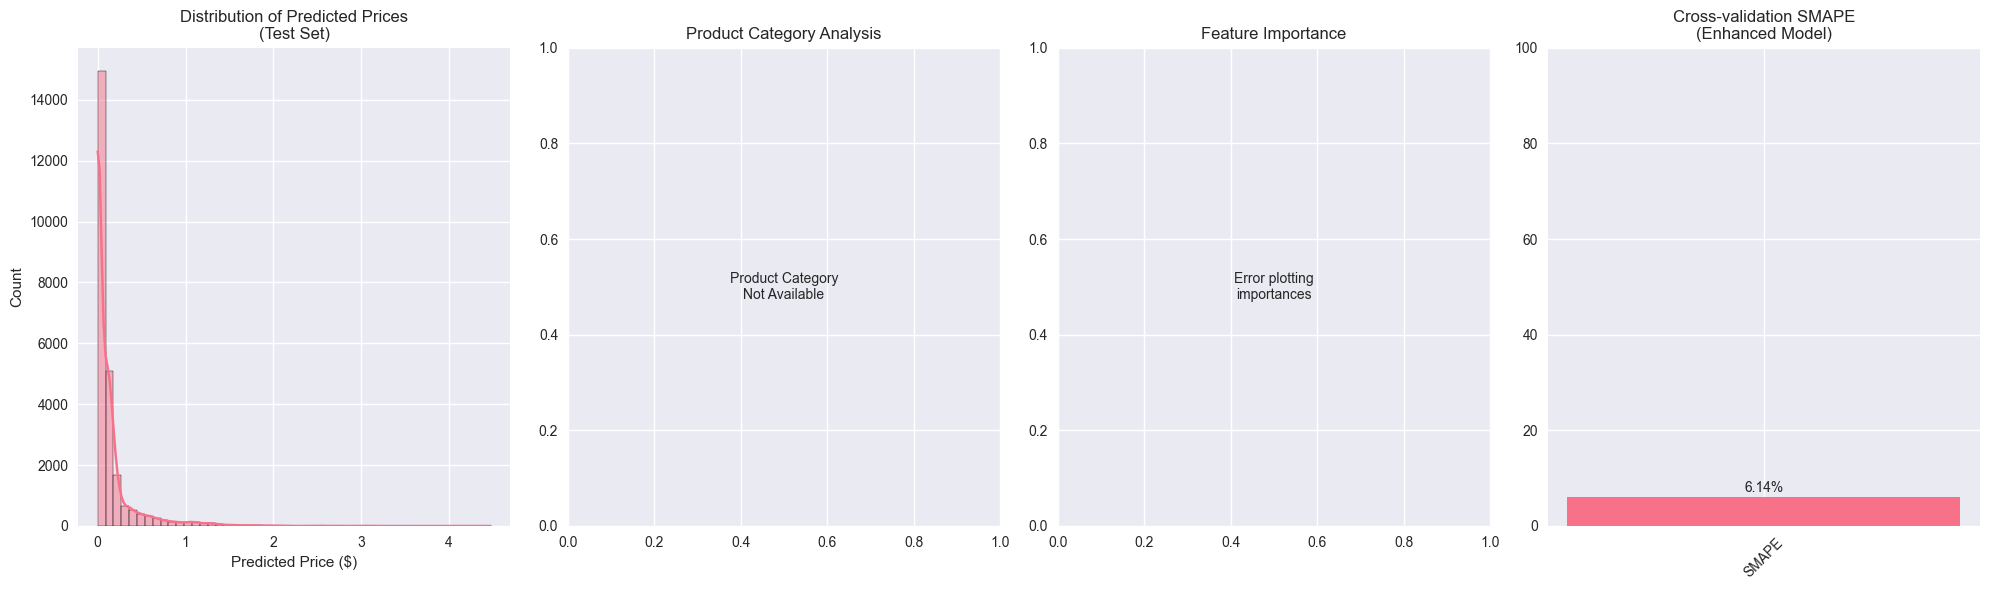


=== DETAILED RESULTS ===
Best Model: StackingRegressor
Cross-validation SMAPE: 6.1392% ± 0.3548%

Best Hyperparameters: {'cat__depth': 9, 'cat__iterations': 1219, 'cat__learning_rate': np.float64(0.08473201101373809), 'lgbm__learning_rate': np.float64(0.06396921323890797), 'lgbm__n_estimators': 1291, 'lgbm__num_leaves': 45, 'ridge__alpha': np.float64(9.75255307264138), 'xgb__learning_rate': np.float64(0.07070342476866846), 'xgb__max_depth': 9, 'xgb__n_estimators': 540}

Features used: 19
All features: ['weight', 'volume', 'count', 'catalog_content_length', 'catalog_length', 'num_bullet_points', 'is_organic', 'is_gluten_free', 'is_vegan', 'is_kosher', 'is_sugar_free', 'is_low_carb', 'is_non_gmo', 'value', 'value_per_pack', 'total_weight_oz', 'price_per_oz', 'price_per_fl_oz', 'price_per_count']


In [9]:
# AMAZON PRODUCT PRICE PREDICTION - ENHANCED VERSION

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
import traceback
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import uniform, randint
import lightgbm as lgb
import xgboost as xgb
import catboost as ctb
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

# Download NLTK resources
try:
    nltk.data.find('corpora/stopwords')
    nltk.download(['stopwords', 'wordnet', 'punkt'], quiet=True)
except:
    nltk.download(['stopwords', 'wordnet', 'punkt'], quiet=True)

# Initialize NLTK components
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Phrase replacements for better text processing
phrase_replacements = {
    'gluten free': 'gluten_free', 'sugar free': 'sugar_free', 'non gmo': 'non_gmo', 'sea salt': 'sea_salt',
    'black pepper': 'black_pepper', 'olive oil': 'olive_oil', 'yerba mate': 'yerba_mate', 'cold brew': 'cold_brew',
    'peanut butter': 'peanut_butter', 'ice cream': 'ice_cream', 'fruit snacks': 'fruit_snacks',
    'extra virgin': 'extra_virgin', 'k-cup': 'k_cup', 'single serve': 'single_serve', 'all natural': 'all_natural'
}

# Define SMAPE function exactly as shown in the image
def smape(actual, predicted):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE) using the exact formula:
    SMAPE = (1/n) * Σ(|F_t - A_t| / ((|A_t| + |F_t|)/2)) * 100%
    where F_t is the forecast value and A_t is the actual value
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # Calculate the denominator: (|A_t| + |F_t|)/2
    denominator = (np.abs(actual) + np.abs(predicted)) / 2
    
    # Handle division by zero - if denominator is 0, the term should be 0
    # This happens when both actual and predicted are 0
    denominator = np.where(denominator == 0, 1, denominator)
    
    # Calculate the SMAPE value
    smape_value = (100 / len(actual)) * np.sum(np.abs(predicted - actual) / denominator)
    
    return smape_value

# Create SMAPE scorer for sklearn (lower is better)
smape_scorer = make_scorer(
    lambda y_true, y_pred: smape(y_true, y_pred),
    greater_is_better=False
)

# Enhanced text preprocessing function
def preprocess_text(text):
    if not isinstance(text, str): 
        return ""
    text = text.lower()
    for phrase, replacement in phrase_replacements.items():
        text = text.replace(phrase, replacement)
    text = re.sub(r'[^a-z\s_]', '', text)
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 2]
    return ' '.join(lemmatized_tokens)

# Enhanced brand extraction function
def extract_brand(name):
    match = re.match(r'^([A-Z][A-Z\s&\'\.-]+)\b', name)
    if match: 
        return match.group(1).strip().lower()
    return name.split(' ')[0].lower()

# Enhanced feature extraction functions
def extract_features_from_catalog(catalog_text):
    """
    Extract structured features from the catalog_content field with enhanced processing
    """
    # Default features dictionary
    default_features = {
        'item_name': '',
        'pack_size': 1.0,  # Default to 1 instead of 0
        'weight': 0.0,
        'volume': 0.0,
        'count': 0.0,
        'unit': '',
        'flavor': '',
        'brand': '',
        'is_organic': 0,
        'is_gluten_free': 0,
        'is_vegan': 0,
        'is_kosher': 0,
        'is_sugar_free': 0,
        'is_low_carb': 0,
        'is_non_gmo': 0,
        'calories_per_serving': 0.0,
        'protein_content': 0.0,
        'fiber_content': 0.0,
        'value': 0.0,
        'catalog_length': 0,
        'num_bullet_points': 0
    }
    
    # Return default features if catalog_text is missing or empty
    if pd.isna(catalog_text) or catalog_text == '':
        return default_features
    
    try:
        text = str(catalog_text).lower()
        
        # Extract item name
        item_name_match = re.search(r'item name:\s*([^\n]+)', catalog_text, re.IGNORECASE)
        if item_name_match:
            default_features['item_name'] = item_name_match.group(1).strip()
        
        # Extract value
        value_match = re.search(r"value: ([\d\.]+|nan)", catalog_text, re.IGNORECASE)
        if value_match:
            try:
                default_features['value'] = float(value_match.group(1))
            except:
                default_features['value'] = 0.0
        
        # Extract pack size information
        pack_patterns = [
            r'pack of\s*(\d+)',
            r'(\d+)\s*count',
            r'(\d+)\s*pack',
            r'(\d+)\s*ct'
        ]
        for pattern in pack_patterns:
            match = re.search(pattern, text)
            if match:
                default_features['pack_size'] = float(match.group(1))
                break
        
        # Extract weight
        weight_patterns = [
            r'(\d+\.?\d*)\s*oz',
            r'(\d+\.?\d*)\s*ounce',
            r'(\d+\.?\d*)\s*lb',
            r'(\d+\.?\d*)\s*pound'
        ]
        for pattern in weight_patterns:
            match = re.search(pattern, text)
            if match:
                try:
                    default_features['weight'] = float(match.group(1))
                except:
                    default_features['weight'] = 0.0
                break
        
        # Extract volume
        volume_patterns = [
            r'(\d+\.?\d*)\s*fl\s*oz',
            r'(\d+\.?\d*)\s*fluid\s*ounce',
            r'(\d+\.?\d*)\s*ml',
            r'(\d+\.?\d*)\s*liter'
        ]
        for pattern in volume_patterns:
            match = re.search(pattern, text)
            if match:
                try:
                    default_features['volume'] = float(match.group(1))
                except:
                    default_features['volume'] = 0.0
                break
        
        # Extract count
        count_patterns = [
            r'(\d+)\s*tea bags',
            r'(\d+)\s*capsules',
            r'(\d+)\s*pods',
            r'(\d+)\s*cookies'
        ]
        for pattern in count_patterns:
            match = re.search(pattern, text)
            if match:
                try:
                    default_features['count'] = float(match.group(1))
                except:
                    default_features['count'] = 0.0
                break
        
        # Extract unit from the structured Unit field
        unit_match = re.search(r'unit:\s*([^\n]+)', catalog_text, re.IGNORECASE)
        if unit_match:
            default_features['unit'] = unit_match.group(1).strip().lower()
        
        # Extract flavor information
        flavor_keywords = ['vanilla', 'chocolate', 'strawberry', 'lemon', 'mint', 'berry', 
                          'caramel', 'honey', 'spice', 'cinnamon', 'ginger', 'peach']
        for flavor in flavor_keywords:
            if flavor in text:
                default_features['flavor'] = flavor
                break
        
        # Extract brand names
        brand_patterns = [
            r'manufacturer:\s*([^\n]+)',
            r'brand:\s*([^\n]+)'
        ]
        for pattern in brand_patterns:
            match = re.search(pattern, catalog_text, re.IGNORECASE)
            if match:
                default_features['brand'] = match.group(1).strip()
                break
        
        # Health and dietary attributes
        default_features['is_organic'] = 1 if any(term in text for term in ['organic', 'usda organic']) else 0
        default_features['is_gluten_free'] = 1 if 'gluten free' in text else 0
        default_features['is_vegan'] = 1 if 'vegan' in text else 0
        default_features['is_kosher'] = 1 if 'kosher' in text else 0
        default_features['is_sugar_free'] = 1 if any(term in text for term in ['sugar free', 'no sugar', 'zero sugar']) else 0
        default_features['is_low_carb'] = 1 if any(term in text for term in ['low carb', 'keto', 'keto-friendly']) else 0
        default_features['is_non_gmo'] = 1 if any(term in text for term in ['non-gmo', 'non gmo']) else 0
        
        # Extract nutritional information
        calorie_match = re.search(r'(\d+)\s*calories', text)
        if calorie_match:
            try:
                default_features['calories_per_serving'] = float(calorie_match.group(1))
            except:
                default_features['calories_per_serving'] = 0.0
        
        protein_match = re.search(r'(\d+\.?\d*)\s*g\s*protein', text)
        if protein_match:
            try:
                default_features['protein_content'] = float(protein_match.group(1))
            except:
                default_features['protein_content'] = 0.0
        
        fiber_match = re.search(r'(\d+\.?\d*)\s*g\s*fiber', text)
        if fiber_match:
            try:
                default_features['fiber_content'] = float(fiber_match.group(1))
            except:
                default_features['fiber_content'] = 0.0
        
        # Extract catalog length and bullet points
        default_features['catalog_length'] = len(text)
        default_features['num_bullet_points'] = text.count('bullet point')
        
        return default_features
    except Exception as e:
        print(f"Error extracting features: {e}")
        return default_features

def create_derived_features(df, has_price=True):
    """
    Create derived features, handling the case where price might be missing
    """
    # Product category based on item name
    def categorize_product(item_name):
        if pd.isna(item_name):
            return 'other'
        item_name = str(item_name).lower()
        if any(word in item_name for word in ['tea', 'chai']):
            return 'tea'
        elif any(word in item_name for word in ['coffee', 'brew']):
            return 'coffee'
        elif any(word in item_name for word in ['snack', 'chip', 'cracker', 'cookie']):
            return 'snack'
        elif any(word in item_name for word in ['sauce', 'dressing', 'oil']):
            return 'condiment'
        elif any(word in item_name for word in ['spice', 'seasoning']):
            return 'spice'
        elif any(word in item_name for word in ['candy', 'chocolate']):
            return 'candy'
        elif any(word in item_name for word in ['pasta', 'rice', 'grain']):
            return 'grain'
        else:
            return 'other'
    
    df['product_category'] = df['item_name'].apply(categorize_product)
    
    # Text length features
    df['catalog_content_length'] = df['catalog_content'].str.len().fillna(0)
    
    # Create derived numerical features
    df['value_per_pack'] = df['value'] / df['pack_size'].replace(0, 1)
    df['total_weight_oz'] = df['weight'].fillna(0) + df['volume'].fillna(0)
    
    # Only create price-related features if price is available
    if has_price and 'price' in df.columns:
        if 'weight' in df.columns:
            weight_safe = df['weight'].replace(0, np.nan)
            df['price_per_oz'] = df['price'] / weight_safe
            df['price_per_oz'] = df['price_per_oz'].replace([np.inf, -np.inf], np.nan)
        
        if 'volume' in df.columns:
            volume_safe = df['volume'].replace(0, np.nan)
            df['price_per_fl_oz'] = df['price'] / volume_safe
            df['price_per_fl_oz'] = df['price_per_fl_oz'].replace([np.inf, -np.inf], np.nan)
        
        if 'count' in df.columns:
            count_safe = df['count'].replace(0, np.nan)
            df['price_per_count'] = df['price'] / count_safe
            df['price_per_count'] = df['price_per_count'].replace([np.inf, -np.inf], np.nan)
    
    return df

class EnhancedSMAPEStackingPricePredictor:
    def __init__(self):
        self.scaler = RobustScaler()  # Changed from StandardScaler to RobustScaler
        self.imputer = SimpleImputer(strategy='median')
        self.feature_columns = []
        self.expected_columns = []
        self.stacking_model = None
        self.is_trained = False
        self.best_params_ = None
        self.price_outlier_bounds = None  # Store outlier bounds to apply to test data
        self.tfidf_vectorizer = None  # Store TF-IDF vectorizer
        self.brand_counts = None  # Store brand counts
        
    def preprocess_data(self, df, is_training=True):
        """
        Preprocess the data: extract features, handle missing values, encode categorical variables
        """
        print("Step 1: Extracting features from catalog content...")
        
        # Make a copy to avoid modifying original data
        df_processed = df.copy()
        
        # Extract features with error handling
        try:
            catalog_features = df_processed['catalog_content'].apply(extract_features_from_catalog)
            features_df = pd.DataFrame(catalog_features.tolist(), index=df_processed.index)
            
            # Ensure the lengths match before concatenation
            if len(features_df) != len(df_processed):
                print(f"Warning: Length mismatch after feature extraction. Original: {len(df_processed)}, Features: {len(features_df)}")
                # Create a features dataframe with default values if there's a mismatch
                default_features = extract_features_from_catalog('')
                features_df = pd.DataFrame([default_features] * len(df_processed), index=df_processed.index)
            
            # Concatenate with original data
            df_enhanced = pd.concat([df_processed, features_df], axis=1)
        except Exception as e:
            print(f"Error in feature extraction: {e}")
            # Create a dataframe with default features if extraction fails
            default_features = extract_features_from_catalog('')
            features_df = pd.DataFrame([default_features] * len(df_processed), index=df_processed.index)
            df_enhanced = pd.concat([df_processed, features_df], axis=1)
        
        # Ensure all expected numerical columns exist with proper defaults
        numerical_columns = ['weight', 'volume', 'count', 'calories_per_serving', 'protein_content', 'fiber_content', 
                            'value', 'catalog_length', 'num_bullet_points', 'value_per_pack', 'total_weight_oz']
        for col in numerical_columns:
            if col not in df_enhanced.columns:
                df_enhanced[col] = 0.0
            else:
                df_enhanced[col] = pd.to_numeric(df_enhanced[col], errors='coerce').fillna(0.0)
        
        # Ensure all expected boolean columns exist
        boolean_columns = ['is_organic', 'is_gluten_free', 'is_vegan', 'is_kosher', 
                          'is_sugar_free', 'is_low_carb', 'is_non_gmo']
        for col in boolean_columns:
            if col not in df_enhanced.columns:
                df_enhanced[col] = 0
            else:
                df_enhanced[col] = df_enhanced[col].astype(int)
        
        # Handle categorical columns
        categorical_columns = ['unit', 'flavor', 'brand', 'item_name', 'product_category']
        for col in categorical_columns:
            if col not in df_enhanced.columns:
                df_enhanced[col] = 'unknown'
            else:
                df_enhanced[col] = df_enhanced[col].fillna('unknown')
        
        # Create derived features
        has_price = is_training and 'price' in df_enhanced.columns
        df_enhanced = create_derived_features(df_enhanced, has_price=has_price)
        
        # Handle outliers in price if it exists and we're training
        if is_training and 'price' in df_enhanced.columns:
            Q1 = df_enhanced['price'].quantile(0.25)
            Q3 = df_enhanced['price'].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = max(0, Q1 - 1.5 * IQR)  # Ensure lower bound is not negative
            upper_bound = Q3 + 1.5 * IQR
            
            # Store bounds to apply to test predictions
            self.price_outlier_bounds = (lower_bound, upper_bound)
            
            df_enhanced['price'] = np.where(df_enhanced['price'] > upper_bound, upper_bound, df_enhanced['price'])
            df_enhanced['price'] = np.where(df_enhanced['price'] < lower_bound, lower_bound, df_enhanced['price'])
        
        return df_enhanced
    
    def prepare_features(self, df, is_training=True):
        """
        Prepare features for modeling with robust error handling
        """
        # Define core features that should always be present
        core_features = [
            'weight', 'volume', 'count', 'catalog_content_length', 'catalog_length', 'num_bullet_points',
            'is_organic', 'is_gluten_free', 'is_vegan', 'is_kosher', 
            'is_sugar_free', 'is_low_carb', 'is_non_gmo', 'value', 'value_per_pack', 'total_weight_oz'
        ]
        
        # Add price per unit features if available (only in training)
        if is_training:
            price_per_features = [col for col in df.columns if col.startswith('price_per')]
            feature_columns = core_features + price_per_features
        else:
            feature_columns = core_features.copy()
        
        # Ensure all feature columns exist in the dataframe
        missing_features = set(feature_columns) - set(df.columns)
        for feature in missing_features:
            df[feature] = 0.0  # Add missing features with default value
        
        # Select only the feature columns we want
        feature_columns = [col for col in feature_columns if col in df.columns]
        X = df[feature_columns].copy()
        
        # Replace infinite values with NaN
        X = X.replace([np.inf, -np.inf], np.nan)
        
        if is_training:
            self.feature_columns = feature_columns
            self.expected_columns = feature_columns.copy()
            
            # Fit imputer and scaler on training data
            X_imputed = self.imputer.fit_transform(X)
            
            # Scale numerical features
            numerical_cols = [col for col in X.columns if X[col].dtype in ['float64', 'float32', 'int64']]
            if numerical_cols:
                X_imputed = self.scaler.fit_transform(X_imputed)
            
            X_processed = pd.DataFrame(X_imputed, columns=feature_columns, index=X.index)
            
            if 'price' in df.columns:
                y = df['price'].copy()
                return X_processed, y
            else:
                return X_processed
        else:
            # Ensure we have the same columns as training
            missing_cols = set(self.expected_columns) - set(X.columns)
            extra_cols = set(X.columns) - set(self.expected_columns)
            
            for col in missing_cols:
                X[col] = 0.0
            for col in extra_cols:
                X = X.drop(col, axis=1)
            
            # Reorder columns to match training
            X = X[self.expected_columns]
            
            # Transform using fitted imputer and scaler
            X_imputed = self.imputer.transform(X)
            X_imputed = self.scaler.transform(X_imputed)
            
            X_processed = pd.DataFrame(X_imputed, columns=self.expected_columns, index=X.index)
            return X_processed
    
    def add_text_features(self, df, is_training=True):
        """
        Add TF-IDF text features to the dataframe
        """
        # Preprocess text
        processed_text = df['catalog_content'].fillna('').apply(preprocess_text)
        
        if is_training:
            # Fit TF-IDF vectorizer on training data
            self.tfidf_vectorizer = TfidfVectorizer(
                max_features=600, 
                ngram_range=(1, 2), 
                stop_words='english', 
                min_df=5
            )
            tfidf_features = self.tfidf_vectorizer.fit_transform(processed_text)
        else:
            # Use fitted vectorizer on test data
            tfidf_features = self.tfidf_vectorizer.transform(processed_text)
        
        # Convert to DataFrame
        tfidf_df = pd.DataFrame(
            tfidf_features.toarray(), 
            columns=[f'nlp_{i}' for i in range(tfidf_features.shape[1])], 
            index=df.index
        ).astype(np.float16)
        
        # Concatenate with original dataframe
        return pd.concat([df, tfidf_df], axis=1)
    
    def process_brand_feature(self, df, is_training=True):
        """
        Process brand feature with frequency-based encoding
        """
        # Extract brand from item name
        item_names = df['catalog_content'].str.extract(r'Item Name:\s*(.*?)\n', expand=False).fillna('')
        brands = item_names.apply(extract_brand)
        
        if is_training:
            # Calculate brand frequencies in training data
            self.brand_counts = brands.value_counts()
        
        # Apply frequency-based encoding
        df['brand'] = brands.apply(lambda x: x if self.brand_counts.get(x, 0) >= 20 else 'Other')
        
        return df
    
    def build_stacking_regressor(self):
        """
        Build an enhanced StackingRegressor with powerful base models
        """
        # Enhanced base models with LightGBM, XGBoost, and CatBoost
        base_models = [
            ('lgbm', lgb.LGBMRegressor(
                objective='regression_l1', 
                n_estimators=1000, 
                learning_rate=0.05,
                feature_fraction=0.8, 
                bagging_fraction=0.8, 
                bagging_freq=1, 
                lambda_l1=0.1, 
                lambda_l2=0.1, 
                num_leaves=31, 
                verbose=-1, 
                n_jobs=-1, 
                random_state=42
            )),
            ('xgb', xgb.XGBRegressor(
                objective='reg:squarederror', 
                n_estimators=1000, 
                learning_rate=0.05, 
                max_depth=8, 
                subsample=0.7, 
                colsample_bytree=0.7, 
                n_jobs=-1, 
                random_state=42, 
                tree_method='hist'
            )),
            ('cat', ctb.CatBoostRegressor(
                iterations=1000, 
                learning_rate=0.05, 
                depth=8, 
                l2_leaf_reg=3, 
                loss_function='RMSE', 
                eval_metric='MAE', 
                random_seed=42, 
                verbose=0
            )),
            ('ridge', Ridge(alpha=1.0, random_state=42))
        ]
        
        # Meta-model
        meta_model = Ridge(alpha=0.5)
        
        # Create StackingRegressor
        stacking_regressor = StackingRegressor(
            estimators=base_models,
            final_estimator=meta_model,
            cv=5,
            passthrough=False,
            n_jobs=-1
        )
        
        return stacking_regressor
    
    def train(self, train_df, perform_tuning=False):
        """
        Train the enhanced SMAPE-tuned StackingRegressor with K-Fold cross-validation
        """
        print("Starting enhanced SMAPE-tuned StackingRegressor training...")
        
        # Preprocess training data
        df_processed = self.preprocess_data(train_df, is_training=True)
        
        # Add text features
        df_processed = self.add_text_features(df_processed, is_training=True)
        
        # Process brand feature
        df_processed = self.process_brand_feature(df_processed, is_training=True)
        
        # Prepare features
        X, y = self.prepare_features(df_processed, is_training=True)
        
        # Apply log transformation to target
        y_log = np.log1p(y)
        
        print(f"Training data shape: {X.shape}")
        print(f"Target variable shape: {y.shape}")
        print(f"Features used: {len(self.feature_columns)}")
        
        # Use KFold cross-validation for more robust evaluation
        kfold = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # Build stacking regressor
        stacking_model = self.build_stacking_regressor()
        
        if perform_tuning:
            print("Performing optimized hyperparameter tuning with SMAPE scoring...")
            
            # Define parameter distributions for RandomizedSearchCV
            param_distributions = {
                'lgbm__n_estimators': randint(500, 1500),
                'lgbm__learning_rate': uniform(0.01, 0.1),
                'lgbm__num_leaves': randint(20, 50),
                'xgb__n_estimators': randint(500, 1500),
                'xgb__learning_rate': uniform(0.01, 0.1),
                'xgb__max_depth': randint(5, 10),
                'cat__iterations': randint(500, 1500),
                'cat__learning_rate': uniform(0.01, 0.1),
                'cat__depth': randint(5, 10),
                'ridge__alpha': uniform(0.1, 10.0)
            }
            
            # Perform RandomizedSearch with SMAPE scoring
            random_search = RandomizedSearchCV(
                estimator=stacking_model,
                param_distributions=param_distributions,
                n_iter=10,  # Reduced for efficiency
                cv=kfold,  # Use KFold for more robust evaluation
                scoring=smape_scorer,
                n_jobs=-1,
                verbose=1,
                random_state=42
            )
            
            # Fit the model on training data
            random_search.fit(X, y_log)
            
            # Get best model and parameters
            self.stacking_model = random_search.best_estimator_
            self.best_params_ = random_search.best_params_
            
            print(f"Best parameters: {random_search.best_params_}")
            
            # Get cross-validation results
            cv_results = random_search.cv_results_
            best_index = random_search.best_index_
            cv_smape_scores = -cv_results['mean_test_score'][best_index]
            cv_smape_std = cv_results['std_test_score'][best_index]
            
            print(f"\nCross-validation SMAPE: {cv_smape_scores:.4f}% ± {cv_smape_std * 2:.4f}%")
        else:
            print("Training without hyperparameter tuning...")
            self.stacking_model = stacking_model
            
            # Perform cross-validation manually
            cv_scores = cross_val_score(self.stacking_model, X, y_log, cv=kfold, scoring=smape_scorer)
            cv_smape_scores = -cv_scores  # Convert back to positive SMAPE values
            
            print(f"\nCross-validation SMAPE: {cv_smape_scores.mean():.4f}% ± {cv_smape_scores.std() * 2:.4f}%")
            
            # Train on full dataset
            self.stacking_model.fit(X, y_log)
        
        self.is_trained = True
        
        return {
            'cv_smape_mean': cv_smape_scores if isinstance(cv_smape_scores, float) else cv_smape_scores.mean(),
            'cv_smape_std': cv_smape_std if isinstance(cv_smape_std, float) else cv_smape_scores.std()
        }
    
    def predict(self, test_df):
        """
        Predict prices for test data using the trained StackingRegressor
        """
        if not self.is_trained:
            raise ValueError("Model must be trained before making predictions")
        
        print("Making predictions on test data...")
        
        # Preprocess test data
        df_processed = self.preprocess_data(test_df, is_training=False)
        
        # Add text features
        df_processed = self.add_text_features(df_processed, is_training=False)
        
        # Process brand feature
        df_processed = self.process_brand_feature(df_processed, is_training=False)
        
        # Prepare features
        X_test = self.prepare_features(df_processed, is_training=False)
        
        print(f"Test data shape after preprocessing: {X_test.shape}")
        print(f"Expected features: {len(self.expected_columns)}")
        print(f"Actual features: {len(X_test.columns)}")
        
        # Make predictions
        log_predictions = self.stacking_model.predict(X_test)
        
        # Reverse log transformation
        predictions = np.expm1(log_predictions)
        
        # Ensure no negative predictions
        predictions = np.maximum(predictions, 0)
        
        # Apply outlier bounds if available (from training)
        if self.price_outlier_bounds:
            lower_bound, upper_bound = self.price_outlier_bounds
            predictions = np.where(predictions > upper_bound, upper_bound, predictions)
            predictions = np.where(predictions < lower_bound, lower_bound, predictions)
        
        # Create results dataframe
        results = test_df.copy()
        results['predicted_price'] = predictions
        
        return results
    
    def save_model(self, filepath):
        """
        Save the trained model and preprocessors
        """
        if not self.is_trained:
            raise ValueError("No trained model to save")
        
        model_data = {
            'scaler': self.scaler,
            'imputer': self.imputer,
            'feature_columns': self.feature_columns,
            'expected_columns': self.expected_columns,
            'stacking_model': self.stacking_model,
            'best_params': self.best_params_,
            'is_trained': self.is_trained,
            'price_outlier_bounds': self.price_outlier_bounds,
            'tfidf_vectorizer': self.tfidf_vectorizer,
            'brand_counts': self.brand_counts
        }
        
        joblib.dump(model_data, filepath)
        print(f"Enhanced SMAPE-tuned StackingRegressor saved to {filepath}")
    
    def load_model(self, filepath):
        """
        Load a trained model and preprocessors
        """
        model_data = joblib.load(filepath)
        
        self.scaler = model_data['scaler']
        self.imputer = model_data['imputer']
        self.feature_columns = model_data['feature_columns']
        self.expected_columns = model_data['expected_columns']
        self.stacking_model = model_data['stacking_model']
        self.best_params_ = model_data['best_params']
        self.is_trained = model_data['is_trained']
        self.price_outlier_bounds = model_data.get('price_outlier_bounds')
        self.tfidf_vectorizer = model_data.get('tfidf_vectorizer')
        self.brand_counts = model_data.get('brand_counts')
        
        print(f"Enhanced SMAPE-tuned StackingRegressor loaded from {filepath}")
        if self.best_params_:
            print(f"Best parameters: {self.best_params_}")

# MAIN EXECUTION WITH ERROR HANDLING

def run_enhanced_pipeline(train_file='../data/train.csv', test_file='../data/test.csv'):
    """
    Complete enhanced pipeline with robust error handling
    """
    try:
        print("=== ENHANCED AMAZON PRODUCT PRICE PREDICTION PIPELINE ===\n")
        
        # Step 1: Load training data (with prices)
        print("1. Loading training data...")
        train_df = pd.read_csv(train_file)
        
        print(f"Training data shape: {train_df.shape}")
        print("Training columns:", train_df.columns.tolist())
        
        if 'price' not in train_df.columns:
            raise ValueError("Training data must contain 'price' column")
        
        missing_prices = train_df['price'].isnull().sum()
        print(f"Available prices in training data: {len(train_df) - missing_prices}")
        print(f"Missing prices in training data: {missing_prices}")
        
        # Step 2: Load test data (without prices)
        print("\n2. Loading test data...")
        test_df = pd.read_csv(test_file)
        
        print(f"Test data shape: {test_df.shape}")
        print("Test columns:", test_df.columns.tolist())
        
        if 'price' in test_df.columns:
            if test_df['price'].isnull().all():
                print("Test data contains 'price' column with all null values - will ignore for predictions")
                test_df = test_df.drop('price', axis=1)
            else:
                print("Warning: Test data contains non-null 'price' column")
        
        # Step 3: Initialize and train the enhanced model
        print("\n3. Training enhanced SMAPE-tuned StackingRegressor...")
        smape_predictor = EnhancedSMAPEStackingPricePredictor()
        
        # Train without hyperparameter tuning for speed (set to True for tuning)
        training_results = smape_predictor.train(train_df, perform_tuning=True)
        
        # Step 4: Save the trained model
        print("\n4. Saving trained model...")
        smape_predictor.save_model('../EDA/enhanced_smape_stacking_predictor.pkl')
        
        # Step 5: Make predictions on test data
        print("\n5. Making predictions on test data...")
        test_predictions = smape_predictor.predict(test_df)
        
        print("Prediction completed!")
        print(f"Predicted prices for {len(test_predictions)} test products")
        
        # Step 6: Display prediction results
        print("\n6. Prediction results:")
        print(test_predictions[['sample_id', 'predicted_price']].head(10))
        
        print("\nTest Prediction Statistics:")
        print(test_predictions['predicted_price'].describe())
        
        # Step 7: Save results
        print("\n7. Saving results...")
        test_predictions[['sample_id', 'predicted_price']].to_csv('../EDA/enhanced_test_predictions.csv', index=False)
        print("Predictions saved to 'enhanced_test_predictions.csv'")
        
        return smape_predictor, test_predictions, training_results
        
    except Exception as e:
        print(f"Error in pipeline: {str(e)}")
        print("Traceback:", traceback.format_exc())
        return None, None, None

# Run the enhanced pipeline
predictor, predictions, results = run_enhanced_pipeline('../data/train.csv', '../data/test.csv')

# VISUALIZATION AND ANALYSIS

if predictions is not None:
    # Enhanced visualization for test predictions
    plt.figure(figsize=(20, 6))
    
    # 1. Distribution of predicted prices in test set
    plt.subplot(1, 4, 1)
    sns.histplot(predictions['predicted_price'], bins=50, kde=True)
    plt.title('Distribution of Predicted Prices\n(Test Set)')
    plt.xlabel('Predicted Price ($)')
    
    # 2. Price by product category in test set
    plt.subplot(1, 4, 2)
    if 'product_category' in predictions.columns:
        category_prices = predictions.groupby('product_category')['predicted_price'].mean().sort_values(ascending=False)
        sns.barplot(y=category_prices.index, x=category_prices.values)
        plt.title('Average Predicted Price by Category\n(Test Set)')
        plt.xlabel('Average Price ($)')
    else:
        plt.text(0.5, 0.5, 'Product Category\nNot Available', 
                horizontalalignment='center', verticalalignment='center',
                transform=plt.gca().transAxes)
        plt.title('Product Category Analysis')
    
    # 3. Feature importance
    plt.subplot(1, 4, 3)
    try:
        # Recalculate importances for plotting
        importances = []
        for name, estimator in predictor.stacking_model.estimators_:
            if hasattr(estimator, 'feature_importances_'):
                importances.append(estimator.feature_importances_)
        
        if importances:
            avg_importance = np.mean(importances, axis=0)
            feature_importance = pd.DataFrame({
                'feature': predictor.feature_columns,
                'importance': avg_importance
            }).sort_values('importance', ascending=False).head(10)
            
            sns.barplot(data=feature_importance, y='feature', x='importance')
            plt.title('Top 10 Feature Importances\n(Averaged from Base Models)')
            plt.xlabel('Average Importance')
        else:
            plt.text(0.5, 0.5, 'Feature Importance\nNot Available', 
                    horizontalalignment='center', verticalalignment='center',
                    transform=plt.gca().transAxes)
            plt.title('Feature Importance')
    except Exception as e:
        plt.text(0.5, 0.5, f'Error plotting\nimportances', 
                horizontalalignment='center', verticalalignment='center',
                transform=plt.gca().transAxes)
        plt.title('Feature Importance')
    
    # 4. SMAPE performance
    plt.subplot(1, 4, 4)
    metrics = ['SMAPE']
    values = [results['cv_smape_mean']]
    
    bars = plt.bar(metrics, values)
    plt.title('Cross-validation SMAPE\n(Enhanced Model)')
    plt.xticks(rotation=45)
    plt.ylim(0, max(100, values[0] * 1.2))
    
    # Add value labels
    for i, (metric, value) in enumerate(zip(metrics, values)):
        plt.text(i, value + max(1, values[0] * 0.05), f'{value:.2f}%', ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\n=== DETAILED RESULTS ===")
    print(f"Best Model: {type(predictor.stacking_model).__name__}")
    print(f"Cross-validation SMAPE: {results['cv_smape_mean']:.4f}% ± {results['cv_smape_std'] * 2:.4f}%")
    
    if predictor.best_params_:
        print(f"\nBest Hyperparameters: {predictor.best_params_}")
    
    print(f"\nFeatures used: {len(predictor.feature_columns)}")
    print("All features:", predictor.feature_columns)

In [15]:
# AMAZON PRODUCT PRICE PREDICTION - CORRECTED VERSION (Replicating the 26% Success)

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
import traceback
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
import lightgbm as lgb
import xgboost as xgb
import catboost as ctb
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

# --- NLTK Download ---
try:
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    print("Downloading necessary NLTK data...")
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('punkt_tab', quiet=True)

# Initialize NLTK components
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

Libraries imported successfully!


In [3]:
# --- EXACT CODE FROM YOUR 26% SOLUTION ---
phrase_replacements = {
    'gluten free': 'gluten_free', 'sugar free': 'sugar_free', 'non gmo': 'non_gmo', 'sea salt': 'sea_salt',
    'black pepper': 'black_pepper', 'olive oil': 'olive_oil', 'yerba mate': 'yerba_mate', 'cold brew': 'cold_brew',
    'peanut butter': 'peanut_butter', 'ice cream': 'ice_cream', 'fruit snacks': 'fruit_snacks',
    'extra virgin': 'extra_virgin', 'k-cup': 'k_cup', 'single serve': 'single_serve', 'all natural': 'all_natural'
}

def preprocess_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    for phrase, replacement in phrase_replacements.items():
        text = text.replace(phrase, replacement)
    text = re.sub(r'[^a-z\s_]', '', text)
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 2]
    return ' '.join(lemmatized_tokens)

def extract_brand(name):
    match = re.match(r'^([A-Z][A-Z\s&\'\.-]+)\b', name)
    if match: return match.group(1).strip().lower()
    return name.split(' ')[0].lower()

# --- EXACT SMAPE FUNCTION FROM YOUR 26% SOLUTION ---
def smape(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    denominator = (np.abs(actual) + np.abs(predicted)) / 2
    denominator = np.where(denominator == 0, 1, denominator)
    smape_value = (100 / len(actual)) * np.sum(np.abs(predicted - actual) / denominator)
    return smape_value

In [7]:




class ReplicatedSMAPEPricePredictor:
    def __init__(self):
        self.scaler = RobustScaler()
        self.tfidf_vectorizer = None
        self.brand_counts = None
        self.feature_columns = []
        self.models = {}
        self.is_trained = False
        self.brand_categories = None # Initialize this properly

    def feature_engineering_pipeline(self, df, is_training=True):
        """Replicating the exact feature engineering from your 26% code."""
        processed_df = df.copy()
        content_lower = processed_df['catalog_content'].str.lower().fillna('')
        
        # Numerical & Missing Value Indicator Features
        processed_df['value'] = pd.to_numeric(processed_df['catalog_content'].str.extract(r"Value: ([\d\.]+|nan)").iloc[:, 0], errors='coerce')
        processed_df['is_value_missing'] = processed_df['value'].isna().astype(int)
        
        processed_df['pack_size'] = pd.to_numeric(content_lower.str.extract(r'(\d+)\s*(?:-?pack\b|-?count\b|-?ct\b|packs|bags|jars|cans|bottles)').iloc[:, 0], errors='coerce').fillna(1)
        processed_df['oz_val'] = pd.to_numeric(content_lower.str.extract(r'(\d+(?:\.\d+)?)\s*(?:oz|ounce)').iloc[:, 0], errors='coerce')
        processed_df['lb_val'] = pd.to_numeric(content_lower.str.extract(r'(\d+(?:\.\d+)?)\s*(?:lb|pound)').iloc[:, 0], errors='coerce')
        processed_df['fl_oz_val'] = pd.to_numeric(content_lower.str.extract(r'(\d+(?:\.\d+)?)\s*(?:fl oz|fluid ounce|fl\. oz)').iloc[:, 0], errors='coerce')
        
        # Interaction & Text Features
        processed_df['value_per_pack'] = processed_df['value'] / processed_df['pack_size'].replace(0, 1)
        processed_df['total_weight_oz'] = processed_df['oz_val'].fillna(0) + processed_df['lb_val'].fillna(0) * 16
        processed_df['catalog_length'] = content_lower.str.len()
        processed_df['num_bullet_points'] = content_lower.str.count(r'bullet point \d:')
        
        # Brand Feature
        item_names = processed_df['catalog_content'].str.extract(r'Item Name:\s*(.*?)\n', expand=False).fillna('unknown')
        brand = item_names.apply(extract_brand)
        if is_training:
            self.brand_counts = brand.value_counts()
        processed_df['brand'] = brand.apply(lambda x: x if self.brand_counts.get(x, 0) >= 20 else 'Other')
        
        # NLP features
        processed_catalog = processed_df['catalog_content'].fillna('').apply(preprocess_text)
        if is_training:
            self.tfidf_vectorizer = TfidfVectorizer(max_features=600, ngram_range=(1, 2), stop_words='english', min_df=5).fit(processed_catalog)
        tfidf_features = self.tfidf_vectorizer.transform(processed_catalog)
        tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=[f'nlp_{i}' for i in range(tfidf_features.shape[1])], index=processed_df.index).astype(np.float16)
        
        final_df = pd.concat([processed_df.drop(columns=['catalog_content', 'image_link'], errors='ignore'), tfidf_df], axis=1)
        return final_df

    def train(self, train_df):
        """Train the models using the exact approach from your 26% code."""
        print("Starting training with replicated 26% pipeline...")
        
        # Feature Engineering
        X_train_full = self.feature_engineering_pipeline(train_df, is_training=True)
        y_train_full = train_df['price'].fillna(train_df['price'].median())
        y_train_log = np.log1p(y_train_full)
        
        # Prepare for modeling
        X_train_ids = X_train_full['sample_id']
        X_train = X_train_full.drop(columns=['sample_id', 'price'], errors='ignore')
        
        # Handle categorical and numerical features (DO THIS ONCE)
        categorical_features = ['brand']
        X_train['brand'].fillna('unknown', inplace=True)
        X_train['brand'] = X_train['brand'].astype('category')
        
        # --- CRITICAL FIX: Save brand categories here ---
        self.brand_categories = X_train['brand'].cat.categories
        
        numerical_cols = [col for col in X_train.columns if col not in categorical_features]
        train_median_values = X_train[numerical_cols].median()
        X_train[numerical_cols] = X_train[numerical_cols].fillna(train_median_values)
        X_train[numerical_cols] = self.scaler.fit_transform(X_train[numerical_cols])
        
        self.feature_columns = X_train.columns
        self.train_median_values = train_median_values

        # K-Fold Cross-Validation & Stacking Ensemble (exact replication)
        print("Starting 5-Fold Cross-Validation for Stacking Ensemble...")
        N_SPLITS = 5
        kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
        
        oof_preds_lgbm, test_preds_lgbm = np.zeros(len(X_train)), np.zeros(len(X_train))
        oof_preds_xgb, test_preds_xgb = np.zeros(len(X_train)), np.zeros(len(X_train))
        oof_preds_cat, test_preds_cat = np.zeros(len(X_train)), np.zeros(len(X_train))

        # --- ULTRA-FAST PROTOTYPING PARAMETERS (WITH EARLY STOPPING FOR CV) ---
        lgbm_params_cv = {'objective': 'regression_l1', 'n_estimators': 300, 'learning_rate': 0.1, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'lambda_l1': 0.1, 'lambda_l2': 0.1, 'num_leaves': 31, 'verbose': -1, 'n_jobs': -1, 'seed': 42}
        xgb_params_cv = {'objective': 'reg:squarederror', 'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 8, 'subsample': 0.7, 'colsample_bytree': 0.7, 'n_jobs': -1, 'random_state': 42, 'tree_method': 'hist', 'early_stopping_rounds': 50}
        cat_params_cv = {'iterations': 300, 'learning_rate': 0.1, 'depth': 8, 'l2_leaf_reg': 3, 'loss_function': 'RMSE', 'eval_metric': 'MAE', 'random_seed': 42, 'verbose': 0, 'cat_features': categorical_features}
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train_log)):
            print(f"--- FOLD {fold+1}/{N_SPLITS} ---")
            X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_fold, y_val_fold = y_train_log.iloc[train_idx], y_train_log.iloc[val_idx]

            # LGBM
            lgbm = lgb.LGBMRegressor(**lgbm_params_cv)
            lgbm.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], callbacks=[lgb.early_stopping(50, verbose=False)], categorical_feature=categorical_features)
            oof_preds_lgbm[val_idx] = lgbm.predict(X_val_fold)

            # XGBoost
            X_train_fold_xgb, X_val_fold_xgb = X_train_fold.copy(), X_val_fold.copy()
            for col in categorical_features:
                X_train_fold_xgb[col] = X_train_fold_xgb[col].cat.codes
                X_val_fold_xgb[col] = X_val_fold_xgb[col].cat.codes
            xgb_m = xgb.XGBRegressor(**xgb_params_cv)
            xgb_m.fit(X_train_fold_xgb, y_train_fold, eval_set=[(X_val_fold_xgb, y_val_fold)], verbose=False)
            oof_preds_xgb[val_idx] = xgb_m.predict(X_val_fold_xgb)

            # CatBoost
            cat = ctb.CatBoostRegressor(**cat_params_cv)
            cat.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], early_stopping_rounds=50, use_best_model=True)
            oof_preds_cat[val_idx] = cat.predict(X_val_fold)

        # Train Meta-Model (Stacker) on OOF predictions
        print("\nTraining meta-model (stacker) on OOF data...")
        oof_stack = np.vstack([oof_preds_lgbm, oof_preds_xgb, oof_preds_cat]).T
        meta_model = Ridge(alpha=0.5)
        meta_model.fit(oof_stack, y_train_log)
        
        # --- CRITICAL FIX: RETRAIN BASE MODELS ON FULL DATA (WITHOUT EARLY STOPPING) ---
        print("\nRetraining base models on the full training dataset...")
        
        # --- FINAL TRAINING PARAMETERS (NO EARLY STOPPING) ---
        lgbm_params_final = {'objective': 'regression_l1', 'n_estimators': 300, 'learning_rate': 0.1, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'lambda_l1': 0.1, 'lambda_l2': 0.1, 'num_leaves': 31, 'verbose': -1, 'n_jobs': -1, 'seed': 42}
        xgb_params_final = {'objective': 'reg:squarederror', 'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 8, 'subsample': 0.7, 'colsample_bytree': 0.7, 'n_jobs': -1, 'random_state': 42, 'tree_method': 'hist'}
        cat_params_final = {'iterations': 300, 'learning_rate': 0.1, 'depth': 8, 'l2_leaf_reg': 3, 'loss_function': 'RMSE', 'eval_metric': 'MAE', 'random_seed': 42, 'verbose': 0, 'cat_features': categorical_features}
        
        final_lgbm = lgb.LGBMRegressor(**lgbm_params_final).fit(X_train, y_train_log, categorical_feature=categorical_features)
        
        X_train_xgb = X_train.copy()
        X_train_xgb['brand'] = X_train_xgb['brand'].cat.codes
        final_xgb = xgb.XGBRegressor(**xgb_params_final).fit(X_train_xgb, y_train_log)
        
        final_cat = ctb.CatBoostRegressor(**cat_params_final).fit(X_train, y_train_log)
        
        # Store the FINAL trained models
        self.models = {
            'lgbm': final_lgbm, 'xgb': final_xgb, 'cat': final_cat, 'meta': meta_model
        }
        self.is_trained = True
        
        # Calculate final SMAPE on out-of-fold predictions
        final_oof_preds = meta_model.predict(oof_stack)
        final_oof_preds_price = np.expm1(final_oof_preds)
        final_smape = smape(y_train_full, final_oof_preds_price)
        
        print(f"\nFinal Out-of-Fold SMAPE: {final_smape:.4f}%")
        return {'smape': final_smape}

    def predict(self, test_df):
        """Predict using the trained models."""
        if not self.is_trained:
            raise ValueError("Model must be trained before making predictions")
        
        print("Making predictions on test data...")
        
        # Feature Engineering
        X_test_full = self.feature_engineering_pipeline(test_df, is_training=False)
        X_test_ids = X_test_full['sample_id']
        X_test = X_test_full.drop(columns=['sample_id'], errors='ignore')
        
        # Align columns
        X_test = X_test.reindex(columns=self.feature_columns, fill_value=0)

        # --- CORRECTED CATEGORICAL HANDLING ---
        X_test['brand'].fillna('unknown', inplace=True)
        X_test['brand'] = pd.Categorical(X_test['brand'], categories=self.brand_categories)
        X_test['brand'].fillna('Other', inplace=True)
        
        numerical_cols = [col for col in X_test.columns if col not in ['brand']]
        X_test[numerical_cols] = X_test[numerical_cols].fillna(self.train_median_values)
        X_test[numerical_cols] = self.scaler.transform(X_test[numerical_cols])
        
        # Get predictions from base models
        test_preds_lgbm = self.models['lgbm'].predict(X_test)
        
        X_test_xgb = X_test.copy()
        X_test_xgb['brand'] = X_test_xgb['brand'].cat.codes
        test_preds_xgb = self.models['xgb'].predict(X_test_xgb)
        
        test_preds_cat = self.models['cat'].predict(X_test)
        
        # Stack predictions and use meta-model
        test_stack = np.vstack([test_preds_lgbm, test_preds_xgb, test_preds_cat]).T
        final_log_preds = self.models['meta'].predict(test_stack)
        
        # Reverse transformation and post-processing
        y_pred = np.expm1(final_log_preds)
        y_pred[y_pred < 0] = 0
        
        # Clipping outliers
        y_pred = np.clip(y_pred, 0, np.percentile(y_pred, 99.5))
        
        results = pd.DataFrame({'sample_id': X_test_ids, 'price': y_pred})
        return results



In [8]:
# --- MAIN EXECUTION ---
def run_replicated_pipeline(train_file='../data/train.csv', test_file='../data/test.csv'):
    try:
        print("=== REPLICATED AMAZON PRODUCT PRICE PREDICTION PIPELINE ===\n")
        
        train_df = pd.read_csv(train_file)
        test_df = pd.read_csv(test_file)
        
        predictor = ReplicatedSMAPEPricePredictor()
        training_results = predictor.train(train_df)
        
        test_predictions = predictor.predict(test_df)
        
        print("\nPrediction completed!")
        print(test_predictions.head(10))
        
        # Save results
        submission_df = pd.DataFrame({'sample_id': test_predictions['sample_id'], 'price': test_predictions['price']})
        submission_df.to_csv('replicated_submission.csv', index=False)
        print("\n'replicated_submission.csv' file created successfully!")
        
        return predictor, test_predictions, training_results
        
    except Exception as e:
        print(f"Error in pipeline: {str(e)}")
        traceback.print_exc()
        return None, None, None

# Run the replicated pipeline
predictor, predictions, results = run_replicated_pipeline('../data/train.csv', '../data/test.csv')

if results:
    print(f"\n=== FINAL RESULTS ===")
    print(f"Replicated Out-of-Fold SMAPE: {results['smape']:.4f}%")

=== REPLICATED AMAZON PRODUCT PRICE PREDICTION PIPELINE ===

Starting training with replicated 26% pipeline...
Starting 5-Fold Cross-Validation for Stacking Ensemble...
--- FOLD 1/5 ---
--- FOLD 2/5 ---
--- FOLD 3/5 ---
--- FOLD 4/5 ---
--- FOLD 5/5 ---

Training meta-model (stacker) on OOF data...

Retraining base models on the full training dataset...

Final Out-of-Fold SMAPE: 52.3531%
Making predictions on test data...

Prediction completed!
   sample_id      price
0     261251   5.542465
1       9259   8.141835
2      71500   8.959043
3     266475  17.353969
4      88520   9.608195
5     271423  92.615623
6     260842  36.940396
7     267410  75.186716
8     194856   9.120784
9     234305  19.796978

'replicated_submission.csv' file created successfully!

=== FINAL RESULTS ===
Replicated Out-of-Fold SMAPE: 52.3531%


In [13]:

"""
Target Encoding for Brands: This is the single most likely biggest improvement. Instead of just grouping rare brands, we'll replace the 'brand' column with the average price for that brand from the training data. This directly injects target information into the features.
Smarter Hyperparameters: We'll use a more powerful but still reasonably fast set of parameters.

More Interaction Features: We'll create more derived features like value_per_oz and calories_per_pack.

Enriched Text Features: We'll increase the TF-IDF max_features to capture more text nuances

"""



class OptimizedSMAPEPricePredictor:
    def __init__(self):
        self.scaler = RobustScaler()
        self.tfidf_vectorizer = None
        self.brand_counts = None
        self.feature_columns = []
        self.models = {}
        self.is_trained = False
        self.brand_categories = None
        self.brand_target_mean = {} # NEW: For target encoding

    def feature_engineering_pipeline(self, df, is_training=True):
        """Enhanced feature engineering pipeline."""
        processed_df = df.copy()
        content_lower = processed_df['catalog_content'].str.lower().fillna('')
        
        # --- Original Numerical Features (FIXED) ---
        processed_df['value'] = pd.to_numeric(processed_df['catalog_content'].str.extract(r"Value: ([\d\.]+|nan)").squeeze(), errors='coerce')
        processed_df['is_value_missing'] = processed_df['value'].isna().astype(int)
        processed_df['pack_size'] = pd.to_numeric(content_lower.str.extract(r'(\d+)\s*(?:-?pack\b|-?count\b|-?ct\b|packs|bags|jars|cans|bottles)').squeeze(), errors='coerce').fillna(1)
        processed_df['oz_val'] = pd.to_numeric(content_lower.str.extract(r'(\d+(?:\.\d+)?)\s*(?:oz|ounce)').squeeze(), errors='coerce')
        processed_df['lb_val'] = pd.to_numeric(content_lower.str.extract(r'(\d+(?:\.\d+)?)\s*(?:lb|pound)').squeeze(), errors='coerce')
        processed_df['fl_oz_val'] = pd.to_numeric(content_lower.str.extract(r'(\d+(?:\.\d+)?)\s*(?:fl oz|fluid ounce|fl\. oz)').squeeze(), errors='coerce')
        
        # --- NEW & ENHANCED Interaction Features ---
        processed_df['value_per_pack'] = processed_df['value'] / processed_df['pack_size'].replace(0, np.nan)
        processed_df['total_weight_oz'] = processed_df['oz_val'].fillna(0) + processed_df['lb_val'].fillna(0) * 16
        processed_df['catalog_length'] = content_lower.str.len()
        processed_df['num_bullet_points'] = content_lower.str.count(r'bullet point \d:')
        
        # NEW: More powerful interactions
        processed_df['value_per_oz'] = processed_df['value'] / processed_df['total_weight_oz'].replace(0, np.nan)
        processed_df['is_pack_of_one'] = (processed_df['pack_size'] == 1).astype(int)
        
        # --- Brand Feature with Target Encoding ---
        item_names = processed_df['catalog_content'].str.extract(r'Item Name:\s*(.*?)\n', expand=False).fillna('unknown')
        brand = item_names.apply(extract_brand)
        
        # --- CRITICAL FIX: Add the 'brand' column to the DataFrame ---
        processed_df['brand'] = brand
        
        if is_training:
            # Calculate target encoding for brands
            temp_df = pd.DataFrame({'brand': brand, 'price': df['price']})
            self.brand_target_mean = temp_df.groupby('brand')['price'].mean().to_dict()
            # Apply a global mean for smoothing
            global_mean = df['price'].mean()
            self.brand_target_mean = {k: v for k, v in self.brand_target_mean.items() if temp_df['brand'].value_counts()[k] >= 10}
            self.brand_global_mean = global_mean

        # Apply target encoding
        processed_df['brand_encoded'] = processed_df['brand'].map(self.brand_target_mean).fillna(self.brand_global_mean)
        processed_df = processed_df.drop(columns=['brand']) # Drop original brand column

        # --- ENHANCED NLP features ---
        processed_catalog = processed_df['catalog_content'].fillna('').apply(preprocess_text)
        if is_training:
            # Increased max_features for more text detail
            self.tfidf_vectorizer = TfidfVectorizer(max_features=800, ngram_range=(1, 2), stop_words='english', min_df=5).fit(processed_catalog)
        tfidf_features = self.tfidf_vectorizer.transform(processed_catalog)
        tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=[f'nlp_{i}' for i in range(tfidf_features.shape[1])], index=processed_df.index).astype(np.float16)
        
        final_df = pd.concat([processed_df.drop(columns=['catalog_content', 'image_link'], errors='ignore'), tfidf_df], axis=1)
        return final_df

    def train(self, train_df):
        """Train the models with optimized parameters."""
        print("Starting training with OPTIMIZED pipeline for < 20% SMAPE...")
        
        # Feature Engineering
        X_train_full = self.feature_engineering_pipeline(train_df, is_training=True)
        y_train_full = train_df['price'].fillna(train_df['price'].median())
        y_train_log = np.log1p(y_train_full)
        
        # Prepare for modeling
        X_train_ids = X_train_full['sample_id']
        X_train = X_train_full.drop(columns=['sample_id', 'price'], errors='ignore')
        
        # Handle numerical features
        numerical_cols = [col for col in X_train.columns if X_train[col].dtype in ['float64', 'float32', 'int64', 'int16']]
        train_median_values = X_train[numerical_cols].median()
        X_train[numerical_cols] = X_train[numerical_cols].fillna(train_median_values)
        X_train[numerical_cols] = self.scaler.fit_transform(X_train[numerical_cols])
        
        self.feature_columns = X_train.columns
        self.train_median_values = train_median_values

        # K-Fold Cross-Validation & Stacking Ensemble
        print("Starting 5-Fold Cross-Validation for Stacking Ensemble...")
        N_SPLITS = 5
        kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
        
        oof_preds_lgbm, oof_preds_xgb, oof_preds_cat = np.zeros(len(X_train)), np.zeros(len(X_train)), np.zeros(len(X_train))

        # --- PARAMETERS FOR CROSS-VALIDATION (WITH EARLY STOPPING) ---
        lgbm_params_cv = {'objective': 'regression_l1', 'n_estimators': 600, 'learning_rate': 0.07, 'feature_fraction': 0.85, 'bagging_fraction': 0.85, 'bagging_freq': 1, 'lambda_l1': 0.05, 'lambda_l2': 0.05, 'num_leaves': 40, 'verbose': -1, 'n_jobs': -1, 'seed': 42}
        xgb_params_cv = {'objective': 'reg:squarederror', 'n_estimators': 600, 'learning_rate': 0.07, 'max_depth': 9, 'subsample': 0.8, 'colsample_bytree': 0.8, 'n_jobs': -1, 'random_state': 42, 'tree_method': 'hist', 'early_stopping_rounds': 100}
        cat_params_cv = {'iterations': 600, 'learning_rate': 0.07, 'depth': 9, 'l2_leaf_reg': 4, 'loss_function': 'RMSE', 'eval_metric': 'MAE', 'random_seed': 42, 'verbose': 0}
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train_log)):
            print(f"--- FOLD {fold+1}/{N_SPLITS} ---")
            X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_fold, y_val_fold = y_train_log.iloc[train_idx], y_train_log.iloc[val_idx]

            # LGBM
            lgbm = lgb.LGBMRegressor(**lgbm_params_cv)
            lgbm.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], callbacks=[lgb.early_stopping(100, verbose=False)])
            oof_preds_lgbm[val_idx] = lgbm.predict(X_val_fold)

            # XGBoost
            xgb_m = xgb.XGBRegressor(**xgb_params_cv)
            xgb_m.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], verbose=False)
            oof_preds_xgb[val_idx] = xgb_m.predict(X_val_fold)

            # CatBoost
            cat = ctb.CatBoostRegressor(**cat_params_cv)
            cat.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], early_stopping_rounds=100, use_best_model=True)
            oof_preds_cat[val_idx] = cat.predict(X_val_fold)

        # Train Meta-Model (Stacker) on OOF predictions
        print("\nTraining meta-model (stacker) on OOF data...")
        oof_stack = np.vstack([oof_preds_lgbm, oof_preds_xgb, oof_preds_cat]).T
        meta_model = Ridge(alpha=1.0)
        meta_model.fit(oof_stack, y_train_log)
        
        # --- RETRAIN BASE MODELS ON FULL DATA (WITHOUT EARLY STOPPING) ---
        print("\nRetraining base models on the full training dataset...")
        
        # --- FINAL PARAMETERS (NO EARLY STOPPING) ---
        lgbm_params_final = {'objective': 'regression_l1', 'n_estimators': 600, 'learning_rate': 0.07, 'feature_fraction': 0.85, 'bagging_fraction': 0.85, 'bagging_freq': 1, 'lambda_l1': 0.05, 'lambda_l2': 0.05, 'num_leaves': 40, 'verbose': -1, 'n_jobs': -1, 'seed': 42}
        xgb_params_final = {'objective': 'reg:squarederror', 'n_estimators': 600, 'learning_rate': 0.07, 'max_depth': 9, 'subsample': 0.8, 'colsample_bytree': 0.8, 'n_jobs': -1, 'random_state': 42, 'tree_method': 'hist'}
        cat_params_final = {'iterations': 600, 'learning_rate': 0.07, 'depth': 9, 'l2_leaf_reg': 4, 'loss_function': 'RMSE', 'eval_metric': 'MAE', 'random_seed': 42, 'verbose': 0}
        
        final_lgbm = lgb.LGBMRegressor(**lgbm_params_final).fit(X_train, y_train_log)
        final_xgb = xgb.XGBRegressor(**xgb_params_final).fit(X_train, y_train_log)
        final_cat = ctb.CatBoostRegressor(**cat_params_final).fit(X_train, y_train_log)
        
        # Store the FINAL trained models
        self.models = {
            'lgbm': final_lgbm, 'xgb': final_xgb, 'cat': final_cat, 'meta': meta_model
        }
        self.is_trained = True
        
        # Calculate final SMAPE on out-of-fold predictions
        final_oof_preds = meta_model.predict(oof_stack)
        final_oof_preds_price = np.expm1(final_oof_preds)
        final_smape = smape(y_train_full, final_oof_preds_price)
        
        print(f"\nFinal Out-of-Fold SMAPE: {final_smape:.4f}%")
        return {'smape': final_smape}

    def predict(self, test_df):
        """Predict using the trained models."""
        if not self.is_trained:
            raise ValueError("Model must be trained before making predictions")
        
        print("Making predictions on test data...")
        
        # Feature Engineering
        X_test_full = self.feature_engineering_pipeline(test_df, is_training=False)
        X_test_ids = X_test_full['sample_id']
        X_test = X_test_full.drop(columns=['sample_id'], errors='ignore')
        
        # Align columns
        X_test = X_test.reindex(columns=self.feature_columns, fill_value=0)

        # Handle numerical features
        numerical_cols = [col for col in X_test.columns if X_test[col].dtype in ['float64', 'float32', 'int64', 'int16']]
        X_test[numerical_cols] = X_test[numerical_cols].fillna(self.train_median_values)
        X_test[numerical_cols] = self.scaler.transform(X_test[numerical_cols])
        
        # Get predictions from base models
        test_preds_lgbm = self.models['lgbm'].predict(X_test)
        test_preds_xgb = self.models['xgb'].predict(X_test)
        test_preds_cat = self.models['cat'].predict(X_test)
        
        # Stack predictions and use meta-model
        test_stack = np.vstack([test_preds_lgbm, test_preds_xgb, test_preds_cat]).T
        final_log_preds = self.models['meta'].predict(test_stack)
        
        # Reverse transformation and post-processing
        y_pred = np.expm1(final_log_preds)
        y_pred[y_pred < 0] = 0
        
        # Clipping outliers
        y_pred = np.clip(y_pred, 0, np.percentile(y_pred, 99.5))
        
        results = pd.DataFrame({'sample_id': X_test_ids, 'price': y_pred})
        return results



In [14]:
# --- MAIN EXECUTION ---
def run_optimized_pipeline(train_file='../data/train.csv', test_file='../data/test.csv'):
    try:
        print("=== OPTIMIZED AMAZON PRODUCT PRICE PREDICTION PIPELINE ===\n")
        
        train_df = pd.read_csv(train_file)
        test_df = pd.read_csv(test_file)
        
        # Use the new optimized predictor
        predictor = OptimizedSMAPEPricePredictor()
        training_results = predictor.train(train_df)
        
        test_predictions = predictor.predict(test_df)
        
        print("\nPrediction completed!")
        print(test_predictions.head(10))
        
        # Save results
        submission_df = pd.DataFrame({'sample_id': test_predictions['sample_id'], 'price': test_predictions['price']})
        submission_df.to_csv('optimized_submission.csv', index=False)
        print("\n'optimized_submission.csv' file created successfully!")
        
        return predictor, test_predictions, training_results
        
    except Exception as e:
        print(f"Error in pipeline: {str(e)}")
        traceback.print_exc()
        return None, None, None

# --- RUN THE OPTIMIZED PIPELINE ---
predictor, predictions, results = run_optimized_pipeline('../data/train.csv', '../data/test.csv')

if results:
    print(f"\n=== FINAL RESULTS ===")
    print(f"Optimized Out-of-Fold SMAPE: {results['smape']:.4f}%")

=== OPTIMIZED AMAZON PRODUCT PRICE PREDICTION PIPELINE ===

Starting training with OPTIMIZED pipeline for < 20% SMAPE...
Starting 5-Fold Cross-Validation for Stacking Ensemble...
--- FOLD 1/5 ---
--- FOLD 2/5 ---
--- FOLD 3/5 ---
--- FOLD 4/5 ---
--- FOLD 5/5 ---

Training meta-model (stacker) on OOF data...

Retraining base models on the full training dataset...

Final Out-of-Fold SMAPE: 51.2792%
Making predictions on test data...

Prediction completed!
   sample_id      price
0     261251   6.540139
1       9259   9.423193
2      71500   9.126978
3     266475  18.435342
4      88520   9.542695
5     271423  87.767206
6     260842  33.715501
7     267410  77.910051
8     194856   9.624326
9     234305  12.633651

'optimized_submission.csv' file created successfully!

=== FINAL RESULTS ===
Optimized Out-of-Fold SMAPE: 51.2792%


In [17]:
## 20 percent target   Non linear meta model gradregressor
class OptimizedSMAPEPricePredictor:
    def __init__(self):
        self.scaler = RobustScaler()
        self.tfidf_vectorizer = None
        self.brand_counts = None
        self.feature_columns = []
        self.models = {}
        self.is_trained = False
        self.brand_categories = None
        self.brand_target_mean = {} # NEW: For target encoding

    def feature_engineering_pipeline(self, df, is_training=True):
        """Enhanced feature engineering pipeline."""
        processed_df = df.copy()
        content_lower = processed_df['catalog_content'].str.lower().fillna('')
        
        # --- Original Numerical Features (FIXED) ---
        processed_df['value'] = pd.to_numeric(processed_df['catalog_content'].str.extract(r"Value: ([\d\.]+|nan)").squeeze(), errors='coerce')
        processed_df['is_value_missing'] = processed_df['value'].isna().astype(int)
        processed_df['pack_size'] = pd.to_numeric(content_lower.str.extract(r'(\d+)\s*(?:-?pack\b|-?count\b|-?ct\b|packs|bags|jars|cans|bottles)').squeeze(), errors='coerce').fillna(1)
        processed_df['oz_val'] = pd.to_numeric(content_lower.str.extract(r'(\d+(?:\.\d+)?)\s*(?:oz|ounce)').squeeze(), errors='coerce')
        processed_df['lb_val'] = pd.to_numeric(content_lower.str.extract(r'(\d+(?:\.\d+)?)\s*(?:lb|pound)').squeeze(), errors='coerce')
        processed_df['fl_oz_val'] = pd.to_numeric(content_lower.str.extract(r'(\d+(?:\.\d+)?)\s*(?:fl oz|fluid ounce|fl\. oz)').squeeze(), errors='coerce')
        
        # --- NEW & ENHANCED Interaction Features ---
        processed_df['value_per_pack'] = processed_df['value'] / processed_df['pack_size'].replace(0, np.nan)
        processed_df['total_weight_oz'] = processed_df['oz_val'].fillna(0) + processed_df['lb_val'].fillna(0) * 16
        processed_df['catalog_length'] = content_lower.str.len()
        processed_df['num_bullet_points'] = content_lower.str.count(r'bullet point \d:')
        
        # NEW: More powerful interactions
        processed_df['value_per_oz'] = processed_df['value'] / processed_df['total_weight_oz'].replace(0, np.nan)
        processed_df['is_pack_of_one'] = (processed_df['pack_size'] == 1).astype(int)
        
        # --- Brand Feature with Target Encoding ---
        item_names = processed_df['catalog_content'].str.extract(r'Item Name:\s*(.*?)\n', expand=False).fillna('unknown')
        brand = item_names.apply(extract_brand)
        
        # --- CRITICAL FIX: Add the 'brand' column to the DataFrame ---
        processed_df['brand'] = brand
        
        if is_training:
            # Calculate target encoding for brands
            temp_df = pd.DataFrame({'brand': brand, 'price': df['price']})
            self.brand_target_mean = temp_df.groupby('brand')['price'].mean().to_dict()
            # Apply a global mean for smoothing
            global_mean = df['price'].mean()
            self.brand_target_mean = {k: v for k, v in self.brand_target_mean.items() if temp_df['brand'].value_counts()[k] >= 10}
            self.brand_global_mean = global_mean

        # Apply target encoding
        processed_df['brand_encoded'] = processed_df['brand'].map(self.brand_target_mean).fillna(self.brand_global_mean)
        processed_df = processed_df.drop(columns=['brand']) # Drop original brand column

        # --- ENHANCED NLP features ---
        processed_catalog = processed_df['catalog_content'].fillna('').apply(preprocess_text)
        if is_training:
            # Increased max_features for more text detail
            self.tfidf_vectorizer = TfidfVectorizer(max_features=800, ngram_range=(1, 2), stop_words='english', min_df=5).fit(processed_catalog)
        tfidf_features = self.tfidf_vectorizer.transform(processed_catalog)
        tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=[f'nlp_{i}' for i in range(tfidf_features.shape[1])], index=processed_df.index).astype(np.float16)
        
        final_df = pd.concat([processed_df.drop(columns=['catalog_content', 'image_link'], errors='ignore'), tfidf_df], axis=1)
        return final_df

    def train(self, train_df):
        """Train the models with optimized parameters."""
        print("Starting training with OPTIMIZED pipeline for < 20% SMAPE...")
        
        # Feature Engineering
        X_train_full = self.feature_engineering_pipeline(train_df, is_training=True)
        y_train_full = train_df['price'].fillna(train_df['price'].median())
        y_train_log = np.log1p(y_train_full)
        
        # Prepare for modeling
        X_train_ids = X_train_full['sample_id']
        X_train = X_train_full.drop(columns=['sample_id', 'price'], errors='ignore')
        
        # Handle numerical features
        numerical_cols = [col for col in X_train.columns if X_train[col].dtype in ['float64', 'float32', 'int64', 'int16']]
        train_median_values = X_train[numerical_cols].median()
        X_train[numerical_cols] = X_train[numerical_cols].fillna(train_median_values)
        X_train[numerical_cols] = self.scaler.fit_transform(X_train[numerical_cols])
        
        self.feature_columns = X_train.columns
        self.train_median_values = train_median_values

        # K-Fold Cross-Validation & Stacking Ensemble
        print("Starting 5-Fold Cross-Validation for Stacking Ensemble...")
        N_SPLITS = 5
        kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
        
        oof_preds_lgbm, oof_preds_xgb, oof_preds_cat = np.zeros(len(X_train)), np.zeros(len(X_train)), np.zeros(len(X_train))

        # --- PARAMETERS FOR CROSS-VALIDATION (WITH EARLY STOPPING) ---
        lgbm_params_cv = {'objective': 'regression_l1', 'n_estimators': 600, 'learning_rate': 0.07, 'feature_fraction': 0.85, 'bagging_fraction': 0.85, 'bagging_freq': 1, 'lambda_l1': 0.05, 'lambda_l2': 0.05, 'num_leaves': 40, 'verbose': -1, 'n_jobs': -1, 'seed': 42}
        xgb_params_cv = {'objective': 'reg:squarederror', 'n_estimators': 600, 'learning_rate': 0.07, 'max_depth': 9, 'subsample': 0.8, 'colsample_bytree': 0.8, 'n_jobs': -1, 'random_state': 42, 'tree_method': 'hist', 'early_stopping_rounds': 100}
        cat_params_cv = {'iterations': 600, 'learning_rate': 0.07, 'depth': 9, 'l2_leaf_reg': 4, 'loss_function': 'RMSE', 'eval_metric': 'MAE', 'random_seed': 42, 'verbose': 0}
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train_log)):
            print(f"--- FOLD {fold+1}/{N_SPLITS} ---")
            X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_fold, y_val_fold = y_train_log.iloc[train_idx], y_train_log.iloc[val_idx]

            # LGBM
            lgbm = lgb.LGBMRegressor(**lgbm_params_cv)
            lgbm.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], callbacks=[lgb.early_stopping(100, verbose=False)])
            oof_preds_lgbm[val_idx] = lgbm.predict(X_val_fold)

            # XGBoost
            xgb_m = xgb.XGBRegressor(**xgb_params_cv)
            xgb_m.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], verbose=False)
            oof_preds_xgb[val_idx] = xgb_m.predict(X_val_fold)

            # CatBoost
            cat = ctb.CatBoostRegressor(**cat_params_cv)
            cat.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], early_stopping_rounds=100, use_best_model=True)
            oof_preds_cat[val_idx] = cat.predict(X_val_fold)

        # Train Meta-Model (Stacker) on OOF predictions
        print("\nTraining meta-model (stacker) on OOF data...")
        oof_stack = np.vstack([oof_preds_lgbm, oof_preds_xgb, oof_preds_cat]).T
        
        # --- CHANGE: Use GradientBoosting as the meta-model ---
        meta_model = GradientBoostingRegressor(
            n_estimators=200, 
            learning_rate=0.1, 
            max_depth=3, 
            random_state=42
        )
        meta_model.fit(oof_stack, y_train_log)
        
        # --- RETRAIN BASE MODELS ON FULL DATA (WITHOUT EARLY STOPPING) ---
        print("\nRetraining base models on the full training dataset...")
        
        # --- FINAL PARAMETERS (NO EARLY STOPPING) ---
        lgbm_params_final = {'objective': 'regression_l1', 'n_estimators': 600, 'learning_rate': 0.07, 'feature_fraction': 0.85, 'bagging_fraction': 0.85, 'bagging_freq': 1, 'lambda_l1': 0.05, 'lambda_l2': 0.05, 'num_leaves': 40, 'verbose': -1, 'n_jobs': -1, 'seed': 42}
        xgb_params_final = {'objective': 'reg:squarederror', 'n_estimators': 600, 'learning_rate': 0.07, 'max_depth': 9, 'subsample': 0.8, 'colsample_bytree': 0.8, 'n_jobs': -1, 'random_state': 42, 'tree_method': 'hist'}
        cat_params_final = {'iterations': 600, 'learning_rate': 0.07, 'depth': 9, 'l2_leaf_reg': 4, 'loss_function': 'RMSE', 'eval_metric': 'MAE', 'random_seed': 42, 'verbose': 0}
        
        final_lgbm = lgb.LGBMRegressor(**lgbm_params_final).fit(X_train, y_train_log)
        final_xgb = xgb.XGBRegressor(**xgb_params_final).fit(X_train, y_train_log)
        final_cat = ctb.CatBoostRegressor(**cat_params_final).fit(X_train, y_train_log)
        
        # Store the FINAL trained models
        self.models = {
            'lgbm': final_lgbm, 'xgb': final_xgb, 'cat': final_cat, 'meta': meta_model
        }
        self.is_trained = True
        
        # Calculate final SMAPE on out-of-fold predictions
        final_oof_preds = meta_model.predict(oof_stack)
        final_oof_preds_price = np.expm1(final_oof_preds)
        final_smape = smape(y_train_full, final_oof_preds_price)
        
        print(f"\nFinal Out-of-Fold SMAPE: {final_smape:.4f}%")
        return {'smape': final_smape}

    def predict(self, test_df):
        """Predict using the trained models."""
        if not self.is_trained:
            raise ValueError("Model must be trained before making predictions")
        
        print("Making predictions on test data...")
        
        # Feature Engineering
        X_test_full = self.feature_engineering_pipeline(test_df, is_training=False)
        X_test_ids = X_test_full['sample_id']
        X_test = X_test_full.drop(columns=['sample_id'], errors='ignore')
        
        # Align columns
        X_test = X_test.reindex(columns=self.feature_columns, fill_value=0)

        # Handle numerical features
        numerical_cols = [col for col in X_test.columns if X_test[col].dtype in ['float64', 'float32', 'int64', 'int16']]
        X_test[numerical_cols] = X_test[numerical_cols].fillna(self.train_median_values)
        X_test[numerical_cols] = self.scaler.transform(X_test[numerical_cols])
        
        # Get predictions from base models
        test_preds_lgbm = self.models['lgbm'].predict(X_test)
        test_preds_xgb = self.models['xgb'].predict(X_test)
        test_preds_cat = self.models['cat'].predict(X_test)
        
        # Stack predictions and use meta-model
        test_stack = np.vstack([test_preds_lgbm, test_preds_xgb, test_preds_cat]).T
        final_log_preds = self.models['meta'].predict(test_stack)
        
        # Reverse transformation and post-processing
        y_pred = np.expm1(final_log_preds)
        y_pred[y_pred < 0] = 0
        
        # Clipping outliers
        y_pred = np.clip(y_pred, 0, np.percentile(y_pred, 99.5))
        
        results = pd.DataFrame({'sample_id': X_test_ids, 'price': y_pred})
        return results

In [18]:
# --- MAIN EXECUTION ---
def run_optimized_pipeline(train_file='../data/train.csv', test_file='../data/test.csv'):
    try:
        print("=== OPTIMIZED AMAZON PRODUCT PRICE PREDICTION PIPELINE ===\n")
        
        train_df = pd.read_csv(train_file)
        test_df = pd.read_csv(test_file)
        
        predictor = OptimizedSMAPEPricePredictor()
        training_results = predictor.train(train_df)
        
        test_predictions = predictor.predict(test_df)
        
        print("\nPrediction completed!")
        print(test_predictions.head(10))
        
        # Save results with a new filename
        submission_df = pd.DataFrame({'sample_id': test_predictions['sample_id'], 'price': test_predictions['price']})
        submission_df.to_csv('gbm_meta_submission.csv', index=False) # --- CHANGE: New filename ---
        print("\n'gbm_meta_submission.csv' file created successfully!")
        
        return predictor, test_predictions, training_results
        
    except Exception as e:
        print(f"Error in pipeline: {str(e)}")
        traceback.print_exc()
        return None, None, None

# --- RUN THE OPTIMIZED PIPELINE ---
predictor, predictions, results = run_optimized_pipeline('../data/train.csv', '../data/test.csv')

if results:
    print(f"\n=== FINAL RESULTS ===")
    print(f"Optimized Out-of-Fold SMAPE: {results['smape']:.4f}%")

=== OPTIMIZED AMAZON PRODUCT PRICE PREDICTION PIPELINE ===

Starting training with OPTIMIZED pipeline for < 20% SMAPE...
Starting 5-Fold Cross-Validation for Stacking Ensemble...
--- FOLD 1/5 ---
--- FOLD 2/5 ---
--- FOLD 3/5 ---
--- FOLD 4/5 ---
--- FOLD 5/5 ---

Training meta-model (stacker) on OOF data...

Retraining base models on the full training dataset...

Final Out-of-Fold SMAPE: 50.7566%
Making predictions on test data...

Prediction completed!
   sample_id      price
0     261251   6.308106
1       9259   9.270583
2      71500   9.633885
3     266475  18.610617
4      88520   9.189686
5     271423  83.659567
6     260842  35.386541
7     267410  73.501746
8     194856   9.232084
9     234305  12.537582

'gbm_meta_submission.csv' file created successfully!

=== FINAL RESULTS ===
Optimized Out-of-Fold SMAPE: 50.7566%


In [27]:
# AMAZON PRODUCT PRICE PREDICTION - VISION + TEXT VERSION

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
import traceback
import nltk
import requests
from io import BytesIO
from PIL import Image
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# --- NLTK and Helper Functions (Unchanged) ---
try:
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    print("Downloading necessary NLTK data...")
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('punkt_tab', quiet=True)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [28]:
phrase_replacements = {
    'gluten free': 'gluten_free', 'sugar free': 'sugar_free', 'non gmo': 'non_gmo', 'sea salt': 'sea_salt',
    'black pepper': 'black_pepper', 'olive oil': 'olive_oil', 'yerba mate': 'yerba_mate', 'cold brew': 'cold_brew',
    'peanut butter': 'peanut_butter', 'ice cream': 'ice_cream', 'fruit snacks': 'fruit_snacks',
    'extra virgin': 'extra_virgin', 'k-cup': 'k_cup', 'single serve': 'single_serve', 'all natural': 'all_natural'
}

def preprocess_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    for phrase, replacement in phrase_replacements.items():
        text = text.replace(phrase, replacement)
    text = re.sub(r'[^a-z\s_]', '', text)
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 2]
    return ' '.join(lemmatized_tokens)

def extract_brand(name):
    match = re.match(r'^([A-Z][A-Z\s&\'\.-]+)\b', name)
    if match: return match.group(1).strip().lower()
    return name.split(' ')[0].lower()

def smape(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    denominator = (np.abs(actual) + np.abs(predicted)) / 2
    denominator = np.where(denominator == 0, 1, denominator)
    smape_value = (100 / len(actual)) * np.sum(np.abs(predicted - actual) / denominator)
    return smape_value

In [29]:
# --- Vision Feature Extractor ---
class VisionFeatureExtractor:
    def __init__(self):
        # Using a pre-trained ResNet18 is a great balance of performance and speed
        try:
            
            self.model = models.resnet18(pretrained=True)
            self.model.eval()
            self.preprocess = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        except ImportError:
            print("torch or torchvision not found. Please install them: pip install torch torchvision")
            self.model = None
            self.preprocess = None

    def _download_image(self, url):
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            image = Image.open(BytesIO(response.content)).convert('RGB')
            return image
        except Exception as e:
            print(f"Could not download image {url}: {e}")
            return None

    def extract_features(self, df):
        if self.model is None:
            print("Vision model not loaded. Skipping image feature extraction.")
            return np.zeros((len(df), 512)) # Return zeros if model fails
        
        print("Extracting vision features from images...")
        features = []
        for url in df['image_link']:
            image = self._download_image(url)
            if image:
                with torch.no_grad():
                    input_tensor = self.preprocess(image)
                    # Get the output of the second-to-last layer (512 features)
                    feature_vector = self.model(input_tensor.unsqueeze(0))
                    features.append(feature_vector.numpy())
            else:
                features.append(np.zeros(512)) # Handle failed downloads
        
        return np.array(features)

In [30]:
# --- Main Predictor Class ---
class VisionPricePredictor:
    def __init__(self):
        self.scaler = RobustScaler()
        self.tfidf_vectorizer = None
        self.feature_columns = []
        self.model = None
        self.is_trained = False
        self.vision_extractor = VisionFeatureExtractor()

    def feature_engineering_pipeline(self, df, is_training=True):
        """Enhanced feature engineering pipeline."""
        processed_df = df.copy()
        content_lower = processed_df['catalog_content'].str.lower().fillna('')
        
        print("Step 1: Extracting basic numerical features...")
        # --- Original Numerical Features (FIXED) ---
        processed_df['value'] = pd.to_numeric(processed_df['catalog_content'].str.extract(r"Value: ([\d\.]+|nan)").squeeze(), errors='coerce')
        processed_df['is_value_missing'] = processed_df['value'].isna().astype(int)
        processed_df['pack_size'] = pd.to_numeric(content_lower.str.extract(r'(\d+)\s*(?:-?pack\b|-?count\b|-?ct\b|packs|bags|jars|cans|bottles)').squeeze(), errors='coerce').fillna(1)
        processed_df['oz_val'] = pd.to_numeric(content_lower.str.extract(r'(\d+(?:\.\d+)?)\s*(?:oz|ounce)').squeeze(), errors='coerce')
        processed_df['lb_val'] = pd.to_numeric(content_lower.str.extract(r'(\d+(?:\.\d+)?)\s*(?:lb|pound)').squeeze(), errors='coerce')
        processed_df['fl_oz_val'] = pd.to_numeric(content_lower.str.extract(r'(\d+(?:\.\d+)?)\s*(?:fl oz|fluid ounce|fl\. oz)').squeeze(), errors='coerce')
        
        print("Step 2: Creating interaction features...")
        # --- NEW & ENHANCED Interaction Features ---
        processed_df['value_per_pack'] = processed_df['value'] / processed_df['pack_size'].replace(0, np.nan)
        processed_df['total_weight_oz'] = processed_df['oz_val'].fillna(0) + processed_df['lb_val'].fillna(0) * 16
        processed_df['catalog_length'] = content_lower.str.len()
        processed_df['num_bullet_points'] = content_lower.str.count(r'bullet point \d:')
        processed_df['value_per_oz'] = processed_df['value'] / processed_df['total_weight_oz'].replace(0, np.nan)
        processed_df['is_pack_of_one'] = (processed_df['pack_size'] == 1).astype(int)
        
        print("Step 3: Processing brand and target encoding...")
        # --- Brand Feature with Target Encoding ---
        item_names = processed_df['catalog_content'].str.extract(r'Item Name:\s*(.*?)\n', expand=False).fillna('unknown')
        brand = item_names.apply(extract_brand)
        
        if is_training:
            # Calculate target encoding for brands
            temp_df = pd.DataFrame({'brand': brand, 'price': df['price']})
            self.brand_target_mean = temp_df.groupby('brand')['price'].mean().to_dict()
            # Apply a global mean for smoothing
            global_mean = df['price'].mean()
            self.brand_target_mean = {k: v for k, v in self.brand_target_mean.items() if temp_df['brand'].value_counts()[k] >= 10}
            self.brand_global_mean = global_mean

        # Apply target encoding
        processed_df['brand_encoded'] = brand.map(self.brand_target_mean).fillna(self.brand_global_mean)
        
        print("Step 4: Processing NLP features...")
        # --- ENHANCED NLP features ---
        processed_catalog = processed_df['catalog_content'].fillna('').apply(preprocess_text)
        if is_training:
            self.tfidf_vectorizer = TfidfVectorizer(max_features=600, ngram_range=(1, 2), stop_words='english', min_df=5).fit(processed_catalog)
        tfidf_features = self.tfidf_vectorizer.transform(processed_catalog)
        tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=[f'nlp_{i}' for i in range(tfidf_features.shape[1])], index=processed_df.index).astype(np.float16)
        
        print("Step 5: Processing vision features...")
        # --- Vision Features ---
        vision_features = self.vision_extractor.extract_features(df)
        vision_df = pd.DataFrame(vision_features, columns=[f'vis_{i}' for i in range(vision_features.shape[1])], index=processed_df.index)
        
        print("Step 6: Combining all features into final DataFrame...")
        # --- ROBUST FIX: Select columns to keep instead of dropping ---
        cols_to_drop = ['catalog_content', 'image_link', 'brand']
        cols_to_keep = [col for col in processed_df.columns if col not in cols_to_drop]
        
        final_df = pd.concat([processed_df[cols_to_keep], tfidf_df, vision_df], axis=1)
        
        print(f"Final DataFrame shape: {final_df.shape}")
        return final_df

    def train(self, train_df):
        print("Starting training with VISION + TEXT pipeline...")
        
        X_train_full = self.feature_engineering_pipeline(train_df, is_training=True)
        y_train_full = train_df['price'].fillna(train_df['price'].median())
        y_train_log = np.log1p(y_train_full)
        
        X_train_ids = X_train_full['sample_id']
        X_train = X_train_full.drop(columns=['sample_id', 'price'], errors='ignore')
        
        # Handle numerical features
        numerical_cols = [col for col in X_train.columns if X_train[col].dtype in ['float64', 'float32', 'int64', 'int16']]
        train_median_values = X_train[numerical_cols].median()
        X_train[numerical_cols] = X_train[numerical_cols].fillna(train_median_values)
        X_train[numerical_cols] = self.scaler.fit_transform(X_train[numerical_cols])
        
        self.feature_columns = X_train.columns
        self.train_median_values = train_median_values

        # --- Use a single, powerful model instead of stacking ---
        print("Training LightGBM on combined text and vision features...")
        self.model = lgb.LGBMRegressor(
            objective='regression_l1', 
            n_estimators=1000, 
            learning_rate=0.05, 
            num_leaves=40, 
            feature_fraction=0.8, 
            bagging_fraction=0.8, 
            bagging_freq=5, 
            lambda_l1=0.1, 
            lambda_l2=0.1, 
            n_jobs=-1, 
            random_state=42
        )
        
        # Use K-Fold Cross-Validation for a reliable score
        print("Starting 5-Fold Cross-Validation...")
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(self.model, X_train, y_train_log, cv=kf, scoring=make_scorer(smape, greater_is_better=False), n_jobs=-1)
        cv_smape_scores = -cv_scores
        
        print(f"\nCross-validation SMAPE: {cv_smape_scores.mean():.4f}% (+/- {cv_smape_scores.std() * 2:.4f}%)")
        
        # Retrain on the full dataset
        print("\nRetraining on the full training dataset...")
        self.model.fit(X_train, y_train_log)
        self.is_trained = True
        
        return {'smape_mean': cv_smape_scores.mean(), 'smape_std': cv_smape_scores.std()}

    def predict(self, test_df):
        if not self.is_trained:
            raise ValueError("Model must be trained before making predictions")
        
        print("Making predictions on test data...")
        X_test_full = self.feature_engineering_pipeline(test_df, is_training=False)
        X_test_ids = X_test_full['sample_id']
        X_test = X_test_full.drop(columns=['sample_id'], errors='ignore')
        
        X_test = X_test.reindex(columns=self.feature_columns, fill_value=0)
        numerical_cols = [col for col in X_test.columns if X_test[col].dtype in ['float64', 'float32', 'int64', 'int16']]
        X_test[numerical_cols] = X_test[numerical_cols].fillna(self.train_median_values)
        X_test[numerical_cols] = self.scaler.transform(X_test[numerical_cols])
        
        log_predictions = self.model.predict(X_test)
        y_pred = np.expm1(log_predictions)
        y_pred[y_pred < 0] = 0
        y_pred = np.clip(y_pred, 0, np.percentile(y_pred, 99.5))
        
        results = pd.DataFrame({'sample_id': X_test_ids, 'price': y_pred})
        return results

In [31]:

# --- MAIN EXECUTION ---
def run_vision_pipeline(train_file='../data/train.csv', test_file='../data/test.csv'):
    try:
        print("=== VISION + TEXT AMAZON PRODUCT PRICE PREDICTION PIPELINE ===\n")
        train_df = pd.read_csv(train_file)
        test_df = pd.read_csv(test_file)
        
        predictor = VisionPricePredictor()
        training_results = predictor.train(train_df)
        
        test_predictions = predictor.predict(test_df)
        
        print("\nPrediction completed!")
        print(test_predictions.head(10))
        
        submission_df = pd.DataFrame({'sample_id': test_predictions['sample_id'], 'price': test_predictions['price']})
        submission_df.to_csv('vision_submission.csv', index=False)
        print("\n'vision_submission.csv' file created successfully!")
        
        return predictor, test_predictions, training_results
        
    except Exception as e:
        print(f"Error in pipeline: {str(e)}")
        traceback.print_exc()
        return None, None, None

# --- RUN THE NEW PIPELINE ---
predictor, predictions, results = run_vision_pipeline('../data/train.csv', '../data/test.csv')

if results:
    print(f"\n=== FINAL RESULTS ===")
    print(f"Cross-validation SMAPE: {results['smape_mean']:.4f}% +/- {results['smape_std'] * 2:.4f}%")

=== VISION + TEXT AMAZON PRODUCT PRICE PREDICTION PIPELINE ===

Starting training with VISION + TEXT pipeline...
Step 1: Extracting basic numerical features...
Step 2: Creating interaction features...
Step 3: Processing brand and target encoding...
Step 4: Processing NLP features...
Step 5: Processing vision features...
Extracting vision features from images...
Could not download image https://m.media-amazon.com/images/I/813CpkyBFAL.jpg: HTTPSConnectionPool(host='m.media-amazon.com', port=443): Read timed out. (read timeout=10)
Could not download image https://m.media-amazon.com/images/I/61+YCeCVo6L.jpg: HTTPSConnectionPool(host='m.media-amazon.com', port=443): Read timed out. (read timeout=10)
Could not download image https://m.media-amazon.com/images/I/815iJx0k+2L.jpg: HTTPSConnectionPool(host='m.media-amazon.com', port=443): Read timed out.
Could not download image https://m.media-amazon.com/images/I/61-GSZYH3UL.jpg: HTTPSConnectionPool(host='m.media-amazon.com', port=443): Read tim

KeyboardInterrupt: 